<a href="https://colab.research.google.com/github/jbkalmbach/pzflow-paper-2021/blob/main/photo-z/pzflowRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pzflow Photo-Z
This notebook shows how we built the normalizing flow with `pzflow` to learn the joint probability distribution of galaxy magnitudes and redshifts used for the plots in the paper.

## Install packages

**Note**: Run cells in this section every time starting in colab.

In [ ]:
!pip install tables_io
!pip install pzflow
!pip install corner

In [ ]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
! git clone https://github.com/LSSTDESC/RAIL.git
! git clone https://github.com/LSSTDESC/qp
! git clone https://github.com/LSSTDESC/DESC_BPZ.git

In [ ]:
! pip install --upgrade flexcode

In [ ]:
! pip install --upgrade astropy

## Imports

In [1]:
import jax
print(f"jax version is {jax.__version__}")
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
print(f"pzflow version is {pzflow.__version__}")
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow import FlowEnsemble

import os
import pandas as pd

jax version is 0.3.1
pzflow version is 2.0.6


/astro/users/brycek/miniconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/astro/users/brycek/miniconda3/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


## Get and load sample photometric catalogs

**Note**: Run cells in this section every time starting in colab.

The photometric catalog we use in this section is the created using the  notebook CMNN_cat_creation.ipynb in this repository. That notebook creates training and test catalogs using the same dataset used for experiments in the Color Matched Nearest Neighbor (CMNN) papers (Code Repository: https://github.com/dirac-institute/CMNN_Photoz_Estimator, Papers: Graham et al. 2018, AJ, 155, 1 & Graham et al. 2020, AJ, 159, 258).

### Download data

In [ ]:
!wget -O train.cat https://epyc.astro.washington.edu/~brycek/train.cat

In [ ]:
!wget -O test.cat https://epyc.astro.washington.edu/~brycek/test.cat

### Load Data

If data was previously downloaded start here.

In [2]:
trainingset = pd.read_csv('train.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [3]:
trainingset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.900582,25.448562,0.124823,25.635542,0.042729,25.454899,0.033699,24.888279,0.036172,24.562720,0.050165,24.472106,0.150306
1,2.010644,24.952113,0.075436,24.813600,0.021939,24.856853,0.019434,24.923800,0.036793,24.752957,0.063623,24.804617,0.185715
2,0.554774,25.836928,0.174945,25.816929,0.048413,24.947092,0.021429,24.600678,0.029065,24.472055,0.047449,24.657549,0.139597
3,0.627027,24.177630,0.039932,24.087804,0.013474,23.529282,0.007172,23.085825,0.008598,22.980726,0.011430,22.932603,0.033431
4,0.900884,24.373186,0.047188,24.502362,0.017692,24.416018,0.013993,23.894312,0.015807,23.660528,0.021112,23.738579,0.064423


In [4]:
testset = pd.read_csv('test.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [5]:
testset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.648192,24.773679,0.066454,24.486278,0.018180,23.715850,0.008217,23.031361,0.008153,22.725347,0.008862,22.603023,0.023841
1,1.547445,24.848797,0.067937,24.918624,0.023465,24.950455,0.021093,24.856045,0.033861,24.572990,0.048171,24.269002,0.109074
2,0.989217,25.269208,0.093680,25.284407,0.032201,25.073436,0.023355,24.519189,0.027131,23.974104,0.029300,23.839821,0.082798
3,0.654055,24.949006,0.071989,24.243395,0.014922,23.126170,0.005467,22.293219,0.005033,21.992805,0.005000,21.866349,0.012312
4,0.428240,23.472365,0.023495,23.105329,0.007213,22.128869,0.005000,21.879126,0.005000,21.723269,0.005000,21.685455,0.010288


In [6]:
trainingset = trainingset[['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

In [7]:
testset = testset[['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

## Training `pzflow`

In this section we set up `pzflow` to train a photometric redshift estimator using `pzflow`'s error convolution and ensemble abilities.

You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. The data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a normalizing flow to model this data. We will construct a bijector made of two parts:

**1. Rolling Spline Coupling** --  
This is a bijector I created that alternates Neural Spline Couplings and "Rolling" layers.
This is the bijector I would recommend using "out of the box".
It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.


**2. Color Transform** --  
This is a bijector that performs the following transformation:  
$(\theta, \, R, \, u\!-\!g, \, g\!-\!r, \, r\!-\!i, \, i\!-\!z, \, z\!-\!y) \to  (\text{redshift}, \, u, \, g, \, r, \, i, \, z, \, y)$  
where
$\text{redshift} = \mathrm{softplus}(\theta)$
and
$r = R \cdot \sigma_r + \bar{r}$.  
Placing this Color Transform very last in our chain of bijectors means that the normalizing flow is optimizing the Neural Spline parameters to map the Gaussian samples onto the galaxy colors, rather than the galaxy magnitudes.
This is useful, as redshift correlates more directly with galaxy colors.
The value $R$ is just a normalized version of the $r$ band magnitude, which serves as a proxy for overall galaxy luminosity.
In addition, the transformation $\text{redshift} = \mathrm{softplus}(\theta)$ ensures that the sampled redshifts are always positive.

We construct the total bijector by chaining these two bijectors together.

After constructing the bijector, we create the flow by instantiating a `Flow` object.
We have to give it the bijector we just created, as well as the names of the columns in our data set.

In [8]:
# to use the r band as the reference magnitude
ref_idx = trainingset.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [trainingset.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([trainingset['redshift'], 
                      trainingset['r'], 
                      trainingset['u'] - trainingset['g'], 
                      trainingset['g'] - trainingset['r'], 
                      trainingset['r'] - trainingset['i'], 
                      trainingset['i'] - trainingset['z'], 
                      trainingset['z'] - trainingset['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = trainingset.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

# bijector = Chain(
#     RollingSplineCoupling(nlayers),
# )

In [ ]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector)

In [ ]:
# create the normalizing flow
flowEns = FlowEnsemble(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector, N=4)

In [ ]:
%%time
losses = flowEns.train(trainingset, epochs=10, batch_size=256, convolve_errs=True, verbose=True)

Now let's plot the training losses to make sure everything looks like we expect it to...

In [ ]:
for n, l in losses.items():
    plt.plot(l, label=n)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [9]:
samples = flowEns.sample(10000, seed=0)

In [10]:
samples

,redshift,u,g,r,i,z,y
0,1.132512,23.924604,24.098885,23.615099,23.204096,22.372665,22.235516
1,0.974213,22.904678,23.024899,22.957739,22.524002,22.111658,22.066261
2,1.408828,24.673445,25.006016,25.037403,24.864813,24.531567,24.192682
3,0.315744,24.043903,23.571560,22.841831,22.732466,22.624865,22.583866
4,0.698447,26.049429,26.021852,25.566174,24.808697,24.739410,24.770206
...,...,...,...,...,...,...,...
9995,0.299740,23.505245,22.860785,22.184422,22.043894,21.957451,21.918291
9996,0.735257,24.904842,24.702208,24.103540,23.250137,22.965937,22.912382
9997,1.635203,24.699444,24.600702,24.770182,24.593008,24.410524,24.225317
9998,0.320668,23.787140,23.340679,22.575230,22.434755,22.339518,22.266430


<Figure size 864x864 with 0 Axes>

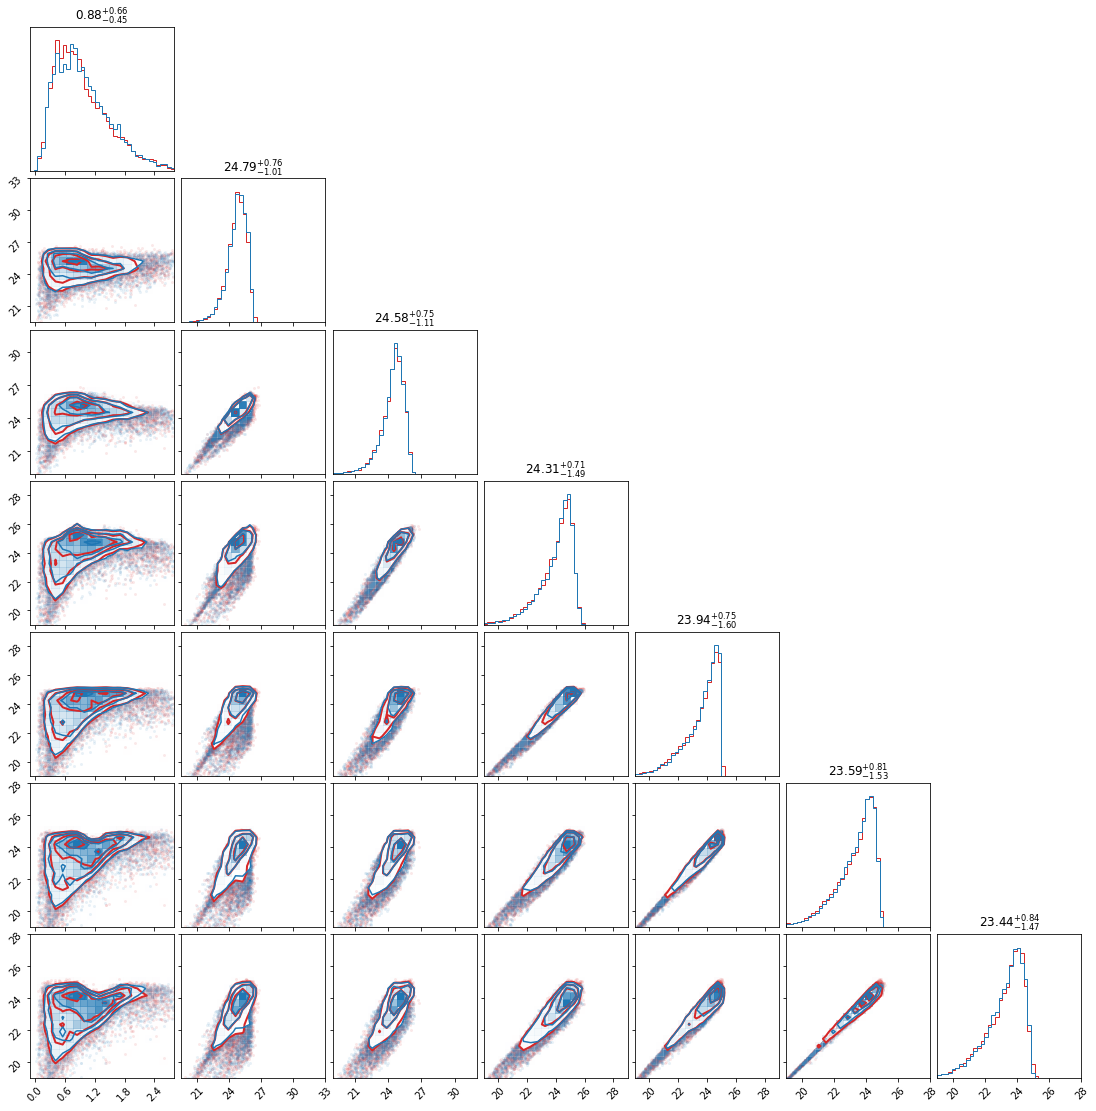

In [11]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.8), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

fig = corner.corner(samples, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(trainingset.iloc[:10000, :7], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

In [12]:
np.min(trainingset['redshift'].values), np.max(trainingset['redshift'].values)

(DeviceArray(0.01511955, dtype=float32), DeviceArray(3.2218933, dtype=float32))

We can also draw posteriors for magnitudes using the more general `posterior` method (in fact, `pz_estimate` is just a redshift wrapper of this method).

We can pass `column` and `grid` to calculate posteriors for different quanities.
For example, lets draw posteriors for the $u$ band:

In [14]:
u_grid = np.arange(21, 30, 0.1)
sample_idx = np.arange(9, 12)
u_pdfs = dict()
u_pdfs = flowEns.posterior(trainingset.iloc[sample_idx], column='u', grid=u_grid)

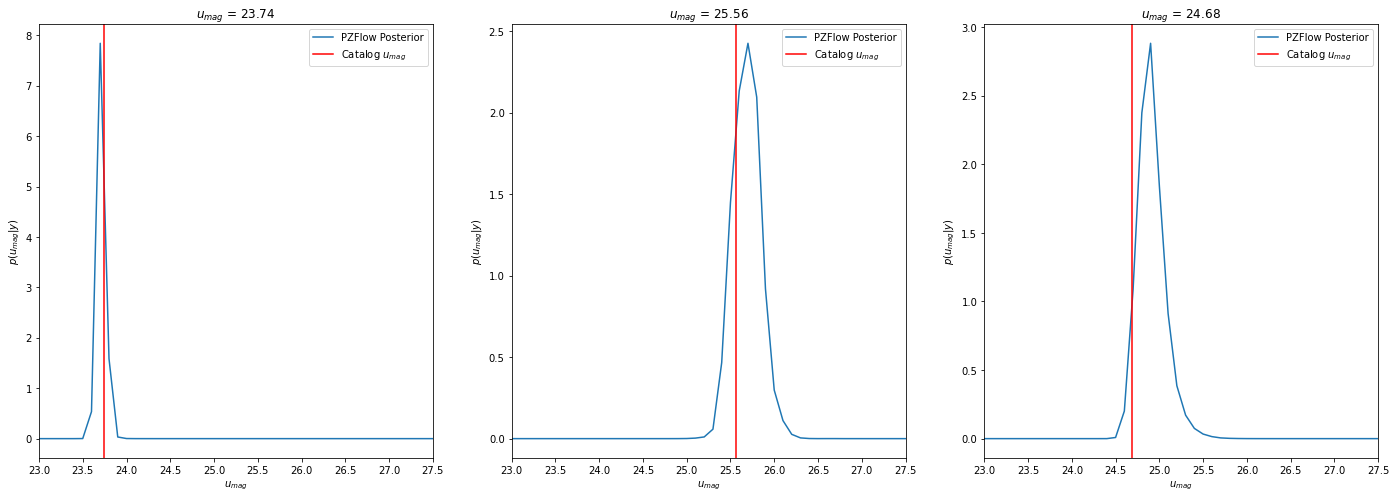

In [15]:
fig = plt.figure(figsize=(24, 8))
for j, idx in list(enumerate(sample_idx)):
  fig.add_subplot(1,3,j+1)
  plt.plot(u_grid, u_pdfs[j], label="PZFlow Posterior")
  plt.axvline(trainingset['u'].iloc[int(idx)], 0, 1, c='r', label='Catalog $u_{mag}$')
  plt.title("$u_{mag}$ = " + f"{trainingset['u'].iloc[int(idx)]:.2f}")
  plt.xlabel("$u_{mag}$")
  plt.ylabel("$p(u_{mag}|y)$")
  plt.legend()
  plt.xlim(23, 27.5)
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [ ]:
flowEns.info = f"""
This is an example flow ensemble, trained on 200,000 simulated galaxies with 
redshifts in the range (0, 3.2) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available to download at:
`https://epyc.astro.washington.edu/~brycek/train.cat`

This flow ensemble was created with pzflow version {pzflow.__version__}
"""

In [16]:
print(flowEns.info)


This is an example flow ensemble, trained on 200,000 simulated galaxies with 
redshifts in the range (0, 3.2) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available to download at:
`https://epyc.astro.washington.edu/~brycek/train.cat`

This flow ensemble was created with pzflow version 2.0.6



Now let's save the flow ensemble to a file that can be loaded later:



In [ ]:
# flowEns.save("lsst-cat-flow-ensemble.pkl")

This file can be loaded on FlowEnsemble instantiation:

In [8]:
flowEns = FlowEnsemble(file="lsst-cat-flow-ensemble.pkl")

## Estimate photo-z's with the flow

In this section we will run the trained flow saved in the section above on the test set to measure photo-z performance using `pzflow`.

First we set up a grid of redshifts for the PDF estimation. A finer grid will provide better resolution but also be slower.

In [9]:
test_batch_size = 2000
zmin = 0.
zmax = 3.5
dz = 0.01
z_grid = np.arange(zmin, zmax+(dz/2), dz)
z_grid_extended = np.arange(zmin, zmax+(3*dz/2), dz)

Use this grid in the `posterior` function to generate the PDFs for redshift for each galaxy.

In [10]:
%%time 
testset_pdfs = flowEns.posterior(testset, 'redshift', z_grid, batch_size=2000, seed=42, returnEnsemble=True)

NameError: name 'flowEns' is not defined

We can save these pdfs for easy loading if we restart the notebook.

In [ ]:
#np.save('testset_pdfs.npy', testset_pdfs)

In [10]:
testset_pdfs = np.load('testset_pdfs.npy')

Here is a sample plot showing the output from each of the 4 flows in our ensemble.

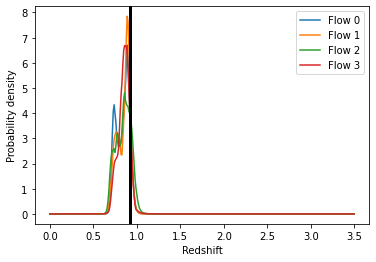

In [11]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

We can average across the ensemble PDFs to get a mean PDF estimate.

In [102]:
mean_test_pdfs = np.mean(testset_pdfs, axis=1)
np.shape(mean_test_pdfs)

(50000, 351)

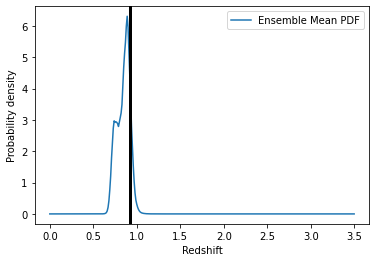

In [13]:
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

*Plot for paper*

Text(0.5, 1.0, 'PZFlow Ensemble and Mean Photo-Z Estimates for a galaxy in the test set')

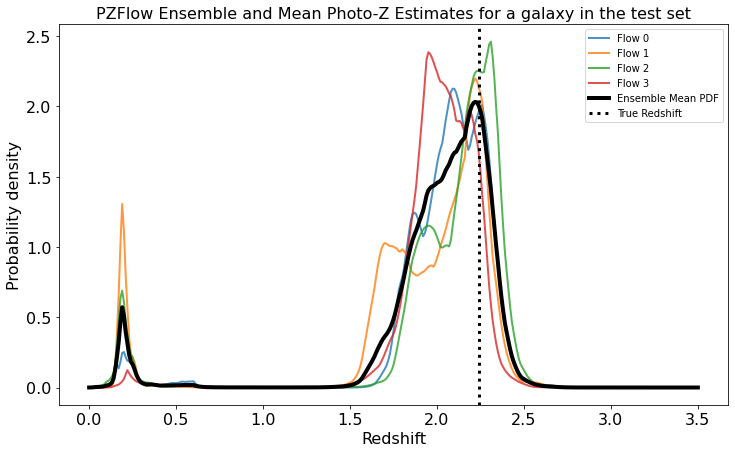

In [14]:
fig = plt.figure(figsize=(12, 7))
n_flows = 4
idx = 29487
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}", alpha=0.8, lw=2)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF", lw=4, c='k')
plt.axvline(testset['redshift'].iloc[idx], 0, 1, linestyle='dotted', lw=3, c='k', label='True Redshift')
plt.xlabel('Redshift', size=16)
plt.ylabel('Probability density', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend()
plt.title('PZFlow Ensemble and Mean Photo-Z Estimates for a galaxy in the test set', size=16)

To get point estimates for the test set photo-z's we will get the mode of the ensemble mean PDF for each galaxy. We will also keep the value of the normalized mean PDF at that point as a measure of our confidence in the estimate.

In [ ]:
%%time
pmaxes = []
zmaxes = []
for pz in mean_test_pdfs:
    pmaxes.append(np.max(pz))
    zmaxes.append(z_grid[pz.argmax()])
pmaxes = np.array(pmaxes)
zmaxes = np.array(zmaxes)

Save for later use

In [ ]:
# np.save('pmaxes.npy', pmaxes)
# np.save('zmaxes.npy', zmaxes)

In [11]:
pmaxes = np.load('pmaxes.npy')
zmaxes = np.load('zmaxes.npy')

Text(0.5, 1.0, 'PZ Flow Mode Point Estimates')

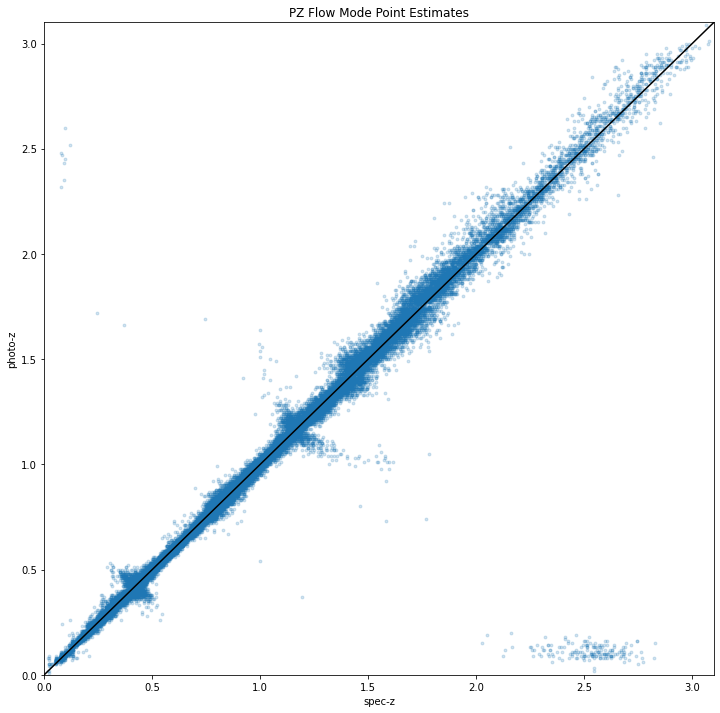

In [18]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(testset['redshift'], zmaxes, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('PZ Flow Mode Point Estimates')

Text(0.5, 1.0, 'PZFlow Mode Point Estimates')

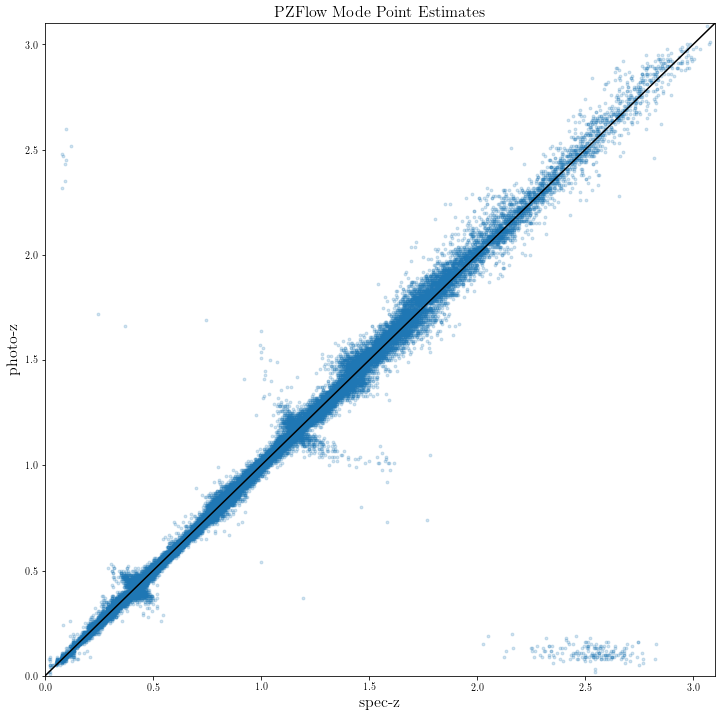

In [52]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(testset['redshift'], zmaxes, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('PZFlow Mode Point Estimates')

We can use the narrowness of the probability distribution as a quality filter. Galaxies with a narrower PDF have photo-z values with less uncertainty.

In [19]:
len(np.where(pmaxes >= 10)[0]), len(np.where(pmaxes < 10)[0])

(36654, 13346)

In [20]:
pgold_idx = np.where(pmaxes >= 10)[0]

In [21]:
len(pmaxes)

50000

In [22]:
np.argmin(pmaxes)

DeviceArray(29487, dtype=int32)

Text(0.5, 1.0, '"Quality cut" on pmax')

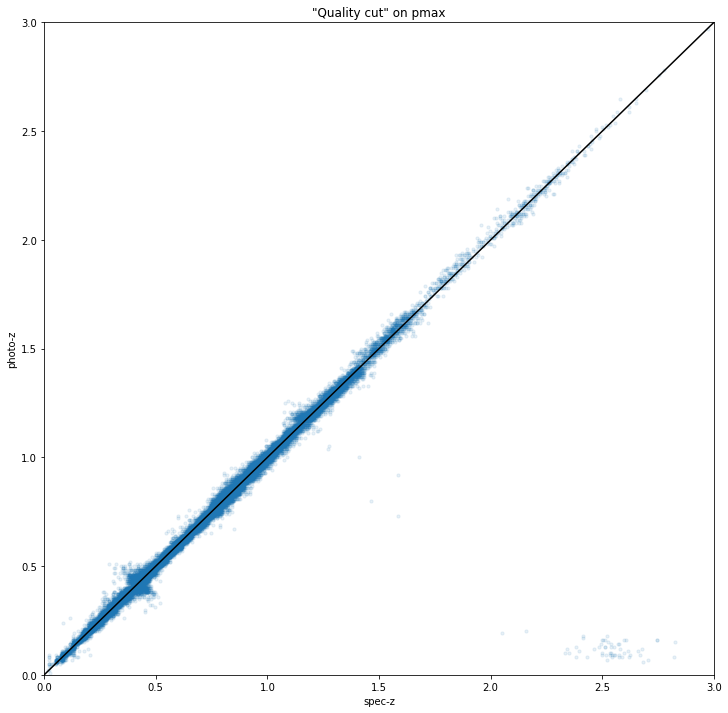

In [23]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(testset['redshift'].iloc[np.where(pmaxes >= 10)], zmaxes[np.where(pmaxes >= 10)], s=10, alpha=0.1)
plt.plot([0,3],[0,3], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.)
plt.ylim(0,3.)
plt.title('"Quality cut" on pmax')

Still some outliers at spec-z ~ 2.5 but overall provides a cleaner looking set of results while keeping 70% of the galaxies.

## Running PZ estimation using RAIL

### Rail imports and set-up

In [12]:
import sys
sys.path.insert(0, "/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL")
sys.path.insert(0, "/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/qp")
sys.path.insert(0, "/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/DESC_BPZ")

In [13]:
import tables_io
import qp

In [14]:
import rail

Found classifier BPZ_lite
Found classifier FZBoost
Found classifier simpleNN
estimator delightPZ not installed
Found classifier KNearNeighPDF
Found classifier PZFlowPDF
Found classifier randomPZ
Found classifier trainZ


/astro/users/brycek/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
import pickle

In [16]:
import yaml

### Prepare training and test data in hdf5 format for RAIL

In [17]:
from copy import copy
trainingset_hdf5 = copy(trainingset)

In [18]:
print(trainingset_hdf5.columns)

Index(['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err',
       'i_err', 'z_err', 'y_err'],
      dtype='object')


In [19]:
trainingset_hdf5.columns=['photometry/redshift', 'photometry/mag_u_lsst', 'photometry/mag_g_lsst', 
                          'photometry/mag_r_lsst', 'photometry/mag_i_lsst', 'photometry/mag_z_lsst', 
                          'photometry/mag_y_lsst', 'photometry/mag_err_u_lsst', 'photometry/mag_err_g_lsst', 
                          'photometry/mag_err_r_lsst', 'photometry/mag_err_i_lsst', 'photometry/mag_err_z_lsst',
                          'photometry/mag_err_y_lsst']

In [20]:
training_dict = trainingset_hdf5.to_dict(orient='list')

In [21]:
import numpy as onp
for key, val in training_dict.items():
  training_dict[key] = onp.array(training_dict[key])

In [22]:
import tables_io
tables_io.ioUtils.writeDictToHdf5(training_dict, 'train_cat.hdf5', None)

Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed

In [23]:
testset_hdf5 = copy(testset)

In [24]:
testset_hdf5.columns = trainingset_hdf5.columns

In [25]:
test_dict = testset_hdf5.to_dict(orient='list')

In [26]:
for key, val in test_dict.items():
  test_dict[key] = onp.array(test_dict[key])

In [27]:
test_dict_missing_g = {}
for key, val in test_dict.items():
    if key not in ['photometry/mag_g_lsst', 'photometry/mag_err_g_lsst']:
        test_dict_missing_g[key] = onp.array(test_dict[key])

In [28]:
test_dict_missing_u = {}
for key, val in test_dict.items():
    if key not in ['photometry/mag_u_lsst', 'photometry/mag_err_u_lsst']:
        test_dict_missing_u[key] = onp.array(test_dict[key])

In [29]:
tables_io.ioUtils.writeDictToHdf5(test_dict, 'test_cat.hdf5', None)

Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed

In [30]:
tables_io.ioUtils.writeDictToHdf5(test_dict_missing_g, 'test_cat_missing_g.hdf5', None)

Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)


In [31]:
tables_io.ioUtils.writeDictToHdf5(test_dict_missing_u, 'test_cat_missing_u.hdf5', None)

Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)
Warning.  Failed to convert column Unable to create dataset (name already exists)


### Test RAIL photo-z estimation with simpleNN

In [39]:
nn_dict = {'run_params': {
  'class_name': 'simpleNN',
  'run_name': 'test_simpleNN',
  'zmin': 0.0,
  'zmax': 3.5,
  'nzbins': 301,
  'width': 0.05,
  'inform_options': {'save_train': True, 'load_model': False, 'modelfile': 'demo_NN_model.pkl'}
  }
}

In [40]:
nn_dict

{'run_params': {'class_name': 'simpleNN',
  'run_name': 'test_simpleNN',
  'zmin': 0.0,
  'zmax': 3.5,
  'nzbins': 301,
  'width': 0.05,
  'inform_options': {'save_train': True,
   'load_model': False,
   'modelfile': 'demo_NN_model.pkl'}}}

In [41]:
with open('RAIL/examples/estimation/example_estimation_base.yaml', 'r') as f:
  estimate_base_yaml = yaml.load(f, Loader=yaml.Loader)

In [42]:
estimate_base_yaml['base_config']['testfile'] = 'test_cat.hdf5'
estimate_base_yaml['base_config']['trainfile'] = 'train_cat.hdf5'

In [43]:
with open('RAIL/examples/estimation/example_estimation_colab.yaml', 'w') as f:
  yaml.dump(estimate_base_yaml, f)

In [44]:
pz = rail.estimation.algos.sklearn_nn.simpleNN('RAIL/examples/estimation/example_estimation_colab.yaml',nn_dict)

summary of input parameters:
width: width (float): The ad hoc base width of the PDFs
width value: 0.05
zmin: zmin (float): The minimum redshift of the z grid
zmin value: 0.0
zmax: zmax (float): The maximum redshift of the z grid
zmax value: 3.5
nzbins: nzbins (int): The number of points in the z grid
nzbins value: 301
param max_iter not included in config, using default value
max_iter: max_iter (int): max number of iterations while training the neural net.  Too low a value will cause an error to be printed (though the code will still work, justnot optimally)
max_iter value: 500
param bands not included in config, using default value
bands: bands (str): bands to use in estimation
bands value: ugrizy
inform_options: inform_options (dict): a dictionary of options for loading and storing of the pretrained model.  This includes:
 modelfile (str): the filename to save or load a trained model to/from
 save_train (bool): boolean to set whether to save a trained model
 load_model (bool): boolea

In [45]:
trainfile = pz.trainfile
train_fmt = 'hdf5'
training_data = tables_io.io.read(trainfile, None, train_fmt)[pz.groupname]

In [46]:
test_data = tables_io.io.read(pz.testfile, None, train_fmt)['photometry']

In [92]:
### Uncomment to retrain model, otherwise load below
# %%time
# pz.inform(training_data)

In [93]:
pz.load_pretrained_model()

success in loading demo_NN_model.pkl


In [94]:
results_dict = pz.estimate(test_data)

In [95]:
test_data['redshift']

array([0.6481919 , 1.547445  , 0.98921716, ..., 0.5938748 , 1.51317   ,
       1.7474971 ])

In [96]:
import matplotlib as mpl
mpl.rcParams['text.usetex']=False

Text(0, 0.5, 'simple NN photo-z')

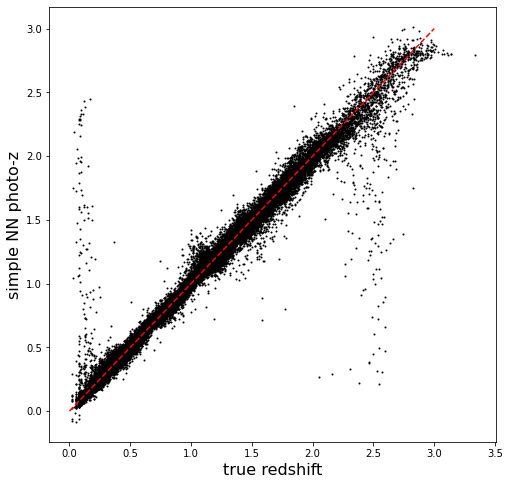

In [97]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],results_dict['zmode'],s=1,c='k',label='simple NN mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("simple NN photo-z")

Text(0, 0.5, 'p(z)')

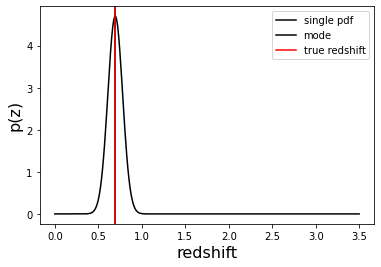

In [98]:
galid = 9529
zgrid = pz.zgrid
single_gal = results_dict['pz_pdf'][galid]
single_zmode = results_dict['zmode'][galid]
truez = test_data['redshift'][galid]
plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmode,color='k',label='mode')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")

Looks like we have our basic set up working

### Calculating photo-z with flexZBoost and RAIL

In [62]:
fz_dict = {'run_params': {
  'class_name': 'FZBoost',
  'run_name': 'test_FZBoost',
  'zmin': 0.0,
  'zmax': 3.5,
  'nzbins': 351,
  'trainfrac': 0.75,
  'bumpmin': 0.02,
  'bumpmax': 0.35,
  'nbump': 20,
  'sharpmin': 0.7,
  'sharpmax': 2.1,
  'nsharp': 15,
  'max_basis': 35,
  'basis_system': 'cosine',
  'regression_params': {'max_depth': 8,'objective':'reg:squarederror'},
  'inform_options': {'save_train': True, 'load_model': False, 'modelfile': 'demo_FZB_model.pkl'}
  }
}

In [63]:
with open('RAIL/examples/estimation/example_estimation_base_qp.yaml', 'r') as f:
  estimate_base_qp_yaml = yaml.load(f, Loader=yaml.Loader)

In [64]:
estimate_base_qp_yaml['base_config']['testfile'] = 'test_cat.hdf5'
estimate_base_qp_yaml['base_config']['trainfile'] = 'train_cat.hdf5'

In [65]:
with open('RAIL/examples/estimation/example_estimation_colab_qp.yaml', 'w') as f:
  yaml.dump(estimate_base_qp_yaml, f)

In [66]:
pzflex = rail.estimation.algos.flexzboost.FZBoost('RAIL/examples/estimation/example_estimation_colab.yaml',fz_dict)

summary of input parameters:
zmin: zmin (float): min value for z grid
zmin value: 0.0
zmax: zmax (float): max value for z grid
zmax value: 3.5
nzbins: nzbins (int): number of z bins
nzbins value: 351
trainfrac: trainfrac (float): fraction of training data to use for training (rest used for bump thresh and sharpening determination)
trainfrac value: 0.75
bumpmin: bumpmin (float): minimum value in grid of thresholds checked to optimize  removal of spurious small bumps
bumpmin value: 0.02
bumpmax: bumpmax (float) max value in grid checked for removal of small bumps
bumpmax value: 0.35
nbump: nbump (int): number of grid points in bumpthresh grid search
nbump value: 20
sharpmin: sharpmin (float): min value in grid checked for optimal sharpening parameter fit
sharpmin value: 0.7
sharpmax: sharpmax (float): max value in grid checked in optimal sharpening parameter fit
sharpmax value: 2.1
nsharp: nsharp (int): number of search points in sharpening fit
nsharp value: 15
max_basis: max_basis (int)

In [67]:
# ! pip install xgboost

In [68]:
### Uncomment to retrain model, otherwise load below
# %%time
# pzflex.inform(training_data)

In [69]:
%%time
pzflex.load_pretrained_model()

success in loading demo_FZB_model.pkl
CPU times: user 5.65 s, sys: 264 ms, total: 5.92 s
Wall time: 6.07 s


In [108]:
# %%time
# flex_results = pzflex.estimate(test_data)

CPU times: user 1min 9s, sys: 1min 3s, total: 2min 13s
Wall time: 45.3 s


In [109]:
# with open('flex_results.pkl', 'wb') as f:
#     pickle.dump(flex_results, f)

In [32]:
with open('flex_results.pkl', 'rb') as f:
    flex_results = pickle.load(f)

In [33]:
fz_modes = flex_results['zmode']

In [34]:
flex_results['pz_pdf']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'flex photo-z')

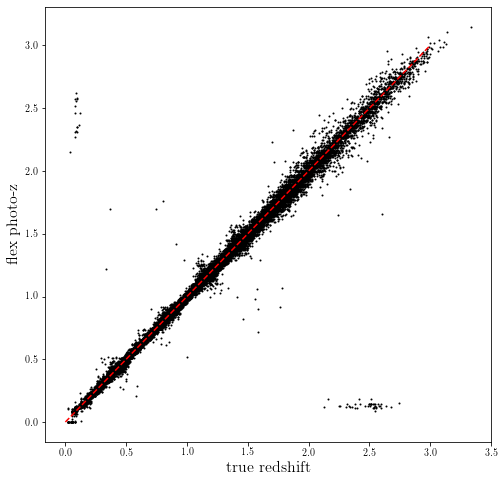

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],fz_modes,s=1,c='k',label='flexz medians')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("flex photo-z")

Text(0.5, 1.0, 'FlexZBoost Mode Point Estimates')

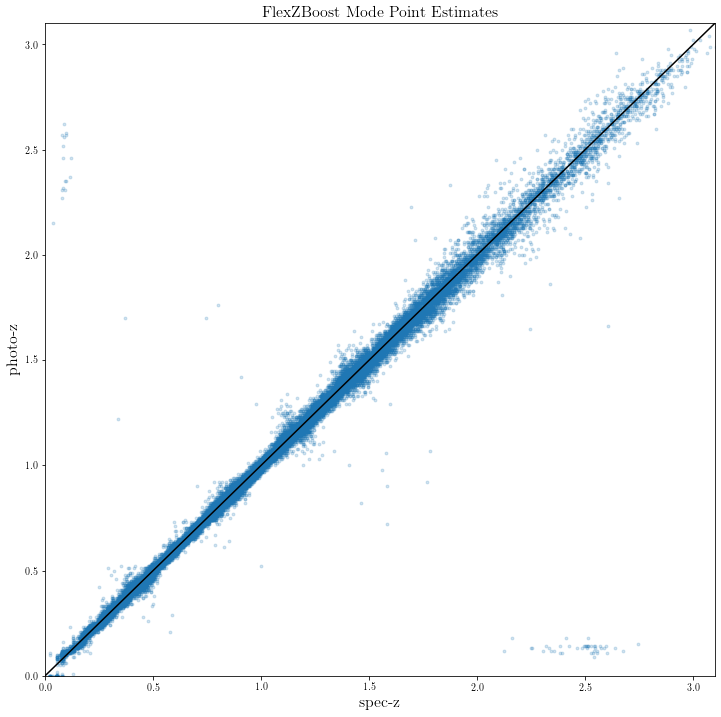

In [49]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(test_data['redshift'],fz_modes, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('FlexZBoost Mode Point Estimates')

In [75]:
plt.plot(flex_results.zgrid, flex_results['pz_pdf'][-100])
plt.axvline(testset['redshift'].iloc[-100])

AttributeError: 'dict' object has no attribute 'zgrid'

### Calculating photo-z with BPZ and RAIL

In [77]:
with open('RAIL/examples/estimation/configs/BPZ_lite.yaml', 'r') as f:
  bpz_params = yaml.load(f, Loader=yaml.Loader)

In [78]:
bpz_params['run_params']['columns_file'] = 'RAIL/examples/estimation/configs/test_bpz.columns'

In [79]:
bpz_params['run_params']['zmax'] = 3.5

In [80]:
# bpz_params['run_params']['spectra_file'] = 'SED/dc2_templates_v4.list'
# bpz_params['run_params']['prior_file'] = 'dc2v4_PCA_cosmodc2v114_py3'
bpz_params['run_params']['zp_errors'] = [0.05, 0.03, 0.03, 0.03, 0.03, 0.04]
bpz_params['run_params']['gauss_kernel'] = 0.05

In [81]:
bpz_params['run_params']['inform_options']['modelfile'] = 'BPZpriormodel.out'

In [82]:
pz_bpz = rail.estimation.algos.bpz_lite.BPZ_lite('RAIL/examples/estimation/example_estimation_colab.yaml',bpz_params)

summary of input parameters:
zmin: zmin (float): min z  for grid
zmin value: 0.0
zmax: zmax (float): max z for grid
zmax value: 3.5
dz: dz (float): delta z in grid
dz value: 0.01
param nzbins not included in config, using default value
nzbins: nzbins (int): # of bins in zgrid
nzbins value: 301
param data_path not included in config, using default value
data_path: data_path (str): file path to the SED, FILTER, and AB directories.  If left to default `None` it will use the install directory for rail + estimation/data
data_path value: None
columns_file: columns_file (str): name of the file specifying the columns
columns_file value: RAIL/examples/estimation/configs/test_bpz.columns
spectra_file: spectra_file (str): name of the file specifying the list of SEDs to use
spectra_file value: SED/CWWSB4.list
param madau_flag not included in config, using default value
madau_flag: madau_flag (str): set to 'yes' or 'no' to set whether to include intergalactic Madau reddening when constructing model

In [83]:
%%time
pz_bpz.inform(training_data)

CPU times: user 10 µs, sys: 12 µs, total: 22 µs
Wall time: 43.4 µs


In [84]:
pz_bpz.load_pretrained_model()

In [123]:
# %%time
# bpz_results = pz_bpz.estimate(test_data)

CPU times: user 30.6 s, sys: 385 ms, total: 31 s
Wall time: 31 s


In [124]:
bpz_results['zmode']

array([0.68, 1.58, 0.92, ..., 0.62, 1.23, 1.37])

In [125]:
# with open('bpz_results_cww.pkl', 'wb') as f:
#     pickle.dump(bpz_results, f)

In [35]:
with open('bpz_results_cww.pkl', 'rb') as f:
    bpz_results = pickle.load(f)

Text(0, 0.5, 'bpz photo-z')

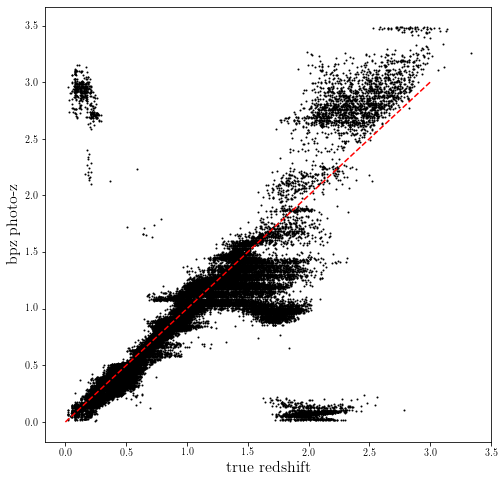

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(test_data['redshift'],bpz_results['zmode'],s=1,c='k',label='bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

Text(0.5, 1.0, 'BPZ Mode Point Estimates')

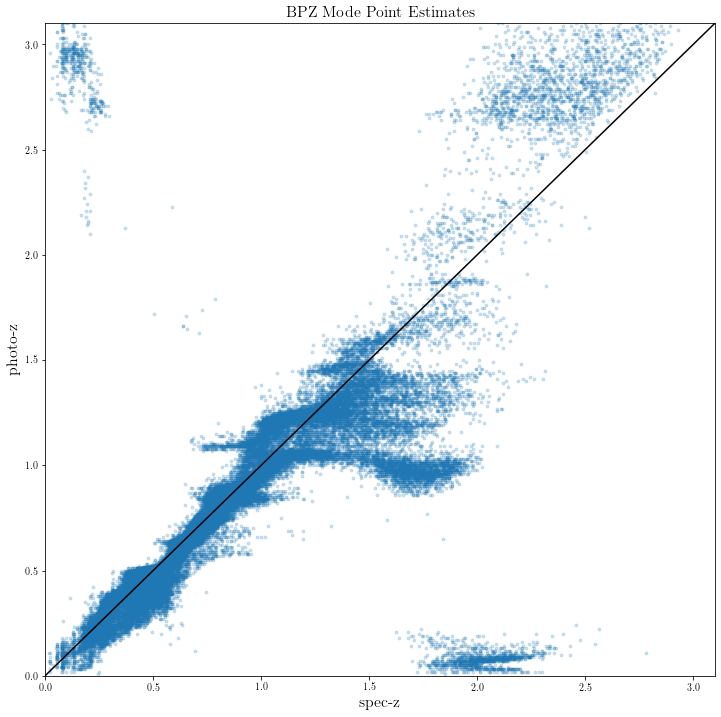

In [51]:
fig,ax = plt.subplots(figsize=(12,12))

plt.scatter(test_data['redshift'],bpz_results['zmode'], s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('BPZ Mode Point Estimates')

In [87]:
bpz_results.keys()

dict_keys(['zmode', 'pz_pdf'])

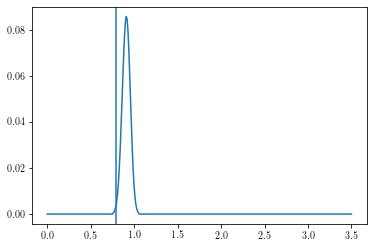

In [88]:
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][-10])
plt.axvline(testset['redshift'].iloc[-100])

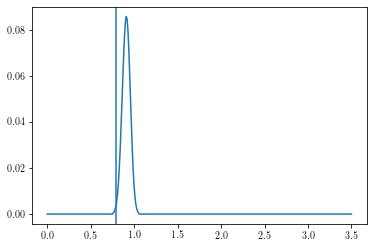

In [89]:
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][-10])
plt.axvline(testset['redshift'].iloc[-100])

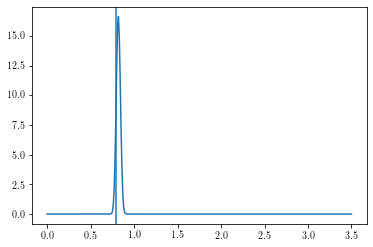

In [90]:
plt.plot(pz_bpz.zgrid, mean_test_pdfs[-100])
plt.axvline(testset['redshift'].iloc[-100])

In [91]:
test_data['redshift'][-100]

0.79452217

## Calculate Point Metrics

In [54]:
from rail.evaluation.metrics.pointestimates import PointBias, PointSigmaIQR, PointOutlierRate, PointSigmaMAD

In [55]:
np.max(testset['redshift'].values)

DeviceArray(3.3378043, dtype=float32)

In [56]:
true_z_bin_idx = np.digitize(testset['redshift'].values, np.arange(0, 3.51, 0.25))

In [57]:
np.max(true_z_bin_idx)

DeviceArray(14, dtype=int32)

#### Point Metrics Binned by Redshift

In [58]:
pzflow_bias_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        pzflow_bias_vals.append(0.0)
        print(bin_num)
        continue
    pzflow_bias = PointBias(zmaxes[bin_idx], testset['redshift'].values[bin_idx])
    pzflow_bias_vals.append(pzflow_bias.evaluate())

In [59]:
flex_bias_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        flex_bias_vals.append(0.0)
        print(bin_num)
        continue
    flex_bias = PointBias(flex_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    flex_bias_vals.append(flex_bias.evaluate())

In [60]:
bpz_bias_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        bpz_bias_vals.append(0.0)
        print(bin_num)
        continue
    bpz_bias = PointBias(bpz_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    bpz_bias_vals.append(bpz_bias.evaluate())

Text(0.5, 1.0, 'Photo-Z Bias')

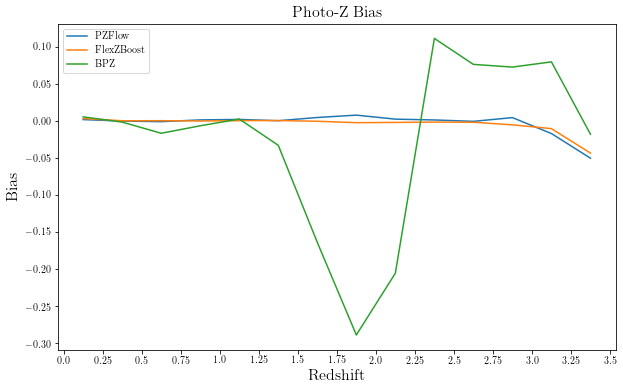

In [61]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_bias_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_bias_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_bias_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Bias')

Text(0.5, 1.0, 'Photo-Z Bias')

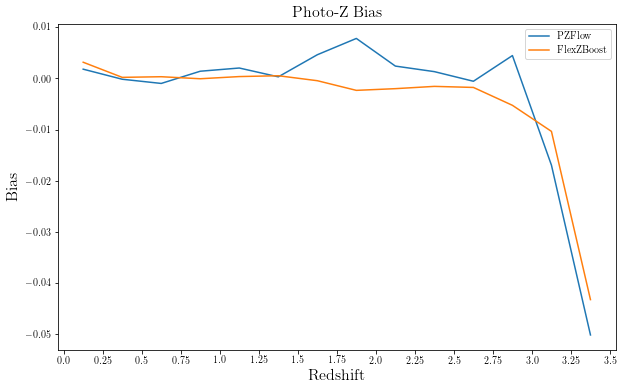

In [62]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_bias_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_bias_vals, label='FlexZBoost')
# plt.plot(np.arange(1, 15)-0.5, bpz_bias_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Bias')

In [63]:
pzflow_iqr_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        pzflow_iqr_vals.append(0.0)
        print(bin_num)
        continue
    pzflow_iqr = PointSigmaIQR(zmaxes[bin_idx], testset['redshift'].values[bin_idx])
    pzflow_iqr_vals.append(pzflow_iqr.evaluate())

In [64]:
flex_iqr_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        flex_iqr_vals.append(0.0)
        print(bin_num)
        continue
    flex_iqr = PointSigmaIQR(flex_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    flex_iqr_vals.append(flex_iqr.evaluate())

In [65]:
bpz_iqr_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        bpz_iqr_vals.append(0.0)
        print(bin_num)
        continue
    bpz_iqr = PointSigmaIQR(bpz_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    bpz_iqr_vals.append(bpz_iqr.evaluate())

Text(0.5, 1.0, 'Photo-Z IQR')

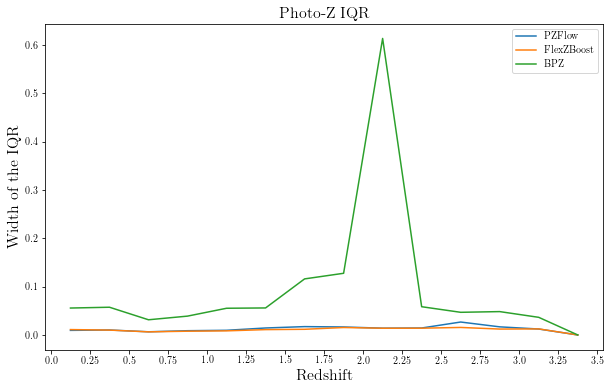

In [66]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_iqr_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_iqr_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_iqr_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the IQR')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z IQR')

Text(0.5, 1.0, 'Photo-Z IQR')

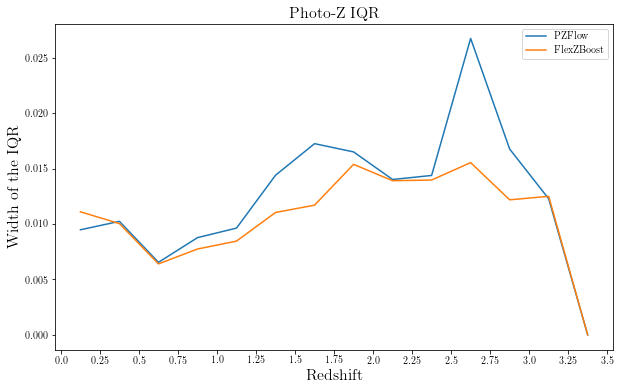

In [67]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_iqr_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_iqr_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_iqr_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the IQR')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z IQR')

In [68]:
pzflow_mad_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        pzflow_mad_vals.append(0.0)
        print(bin_num)
        continue
    pzflow_mad = PointSigmaMAD(zmaxes[bin_idx], testset['redshift'].values[bin_idx])
    pzflow_mad_vals.append(pzflow_mad.evaluate())

In [69]:
flex_mad_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        flex_mad_vals.append(0.0)
        print(bin_num)
        continue
    flex_mad = PointSigmaMAD(flex_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    flex_mad_vals.append(flex_mad.evaluate())

In [70]:
bpz_mad_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        bpz_mad_vals.append(0.0)
        print(bin_num)
        continue
    bpz_mad = PointSigmaMAD(bpz_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    bpz_mad_vals.append(bpz_mad.evaluate())

Text(0.5, 1.0, 'Photo-Z MAD')

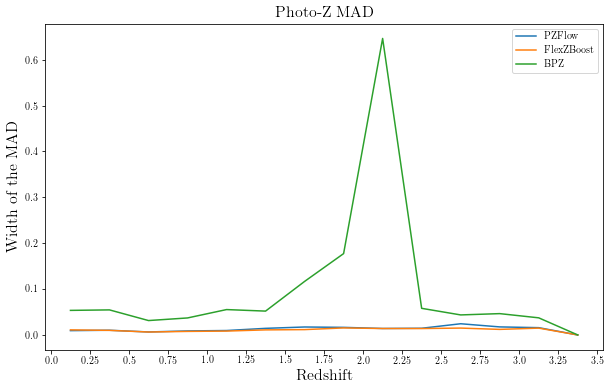

In [71]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_mad_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_mad_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_mad_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the MAD')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z MAD')

Text(0.5, 1.0, 'Photo-Z MAD')

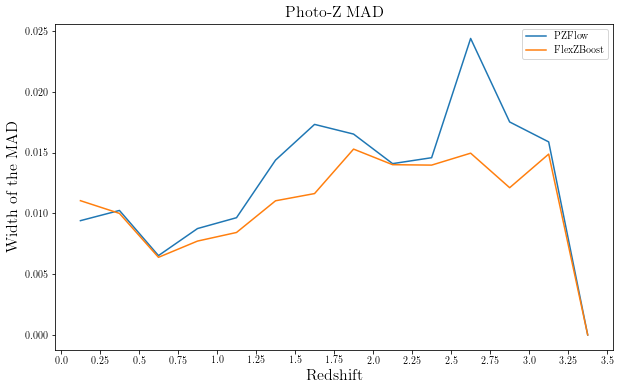

In [72]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_mad_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_mad_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_mad_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the MAD')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z MAD')

In [73]:
pzflow_outlier_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        pzflow_outlier_vals.append(0.0)
        print(bin_num)
        continue
    pzflow_outlier = PointOutlierRate(zmaxes[bin_idx], testset['redshift'].values[bin_idx])
    pzflow_outlier_vals.append(pzflow_outlier.evaluate())

In [74]:
flex_outlier_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        flex_outlier_vals.append(0.0)
        print(bin_num)
        continue
    flex_outlier = PointOutlierRate(flex_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    flex_outlier_vals.append(flex_outlier.evaluate())

In [75]:
bpz_outlier_vals = []
for bin_num in range(1, 15):
    bin_idx = np.where(true_z_bin_idx ==  bin_num)
    if len(bin_idx) == 0:
        bpz_outlier_vals.append(0.0)
        print(bin_num)
        continue
    bpz_outlier = PointOutlierRate(bpz_results['zmode'][bin_idx], testset['redshift'].values[bin_idx])
    bpz_outlier_vals.append(bpz_outlier.evaluate())

Text(0.5, 1.0, 'Photo-Z Outlier Fraction')

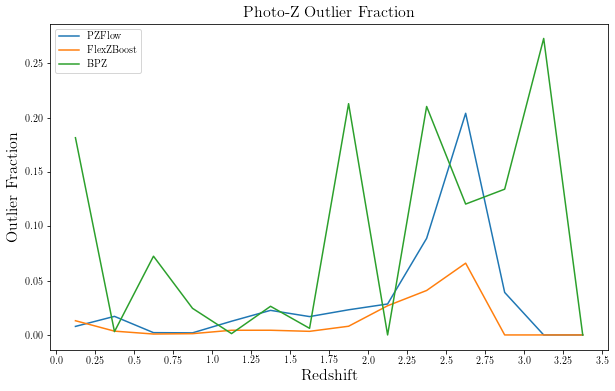

In [76]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_outlier_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_outlier_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_outlier_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Outlier Fraction')

Text(0.5, 1.0, 'Photo-Z Outlier Fraction')

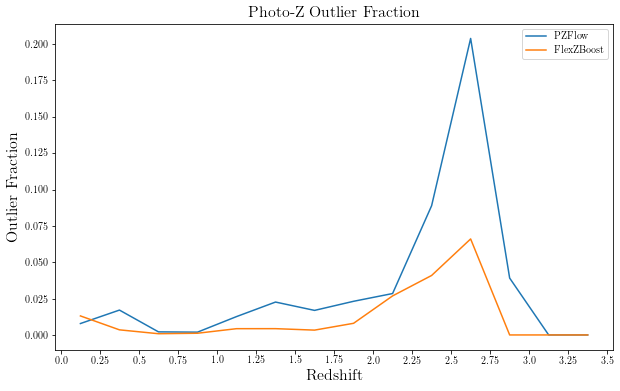

In [77]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 15)-0.5, pzflow_outlier_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_outlier_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_outlier_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Outlier Fraction')

Text(0.5, 1.0, 'Photo-Z Outlier Fraction')

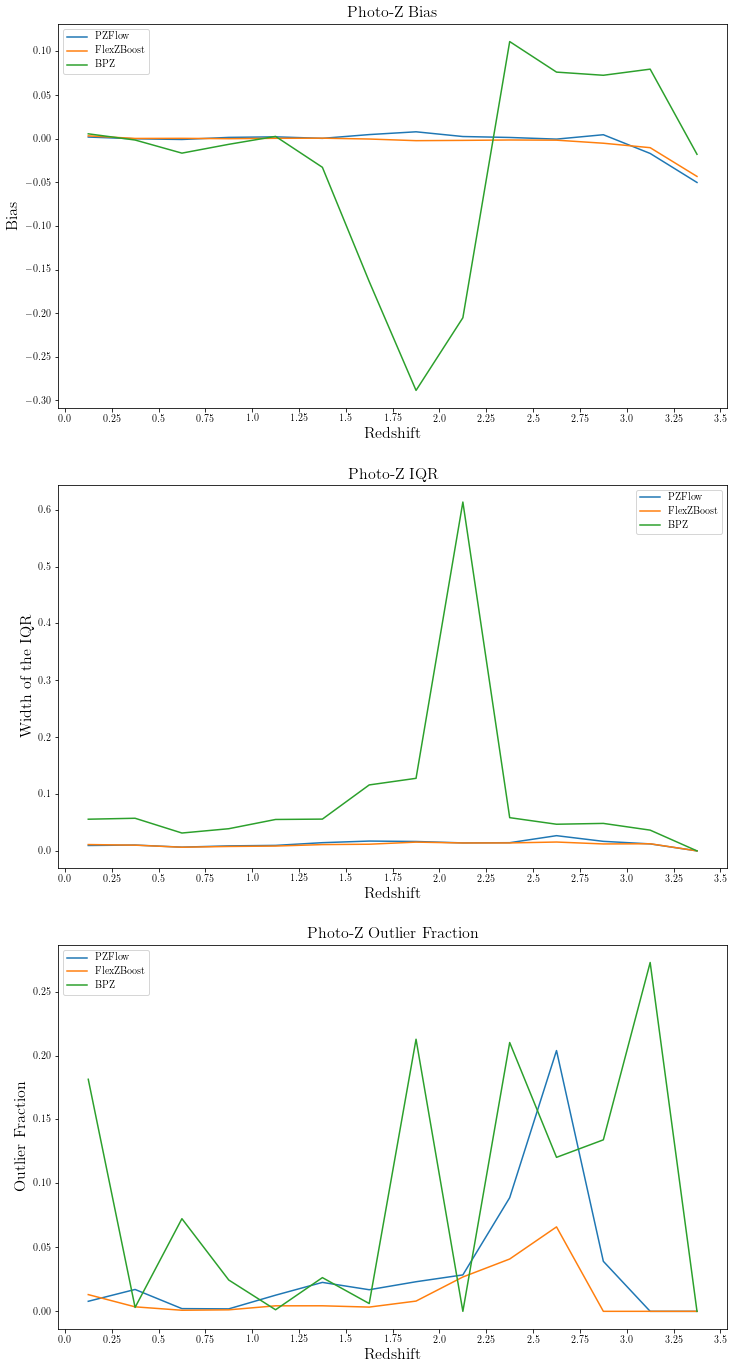

In [81]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(3,1,1)
plt.plot(np.arange(1, 15)-0.5, pzflow_bias_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_bias_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_bias_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Bias')

fig.add_subplot(3,1,2)
plt.plot(np.arange(1, 15)-0.5, pzflow_iqr_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_iqr_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_iqr_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the IQR')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z IQR')

fig.add_subplot(3,1,3)
plt.plot(np.arange(1, 15)-0.5, pzflow_outlier_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_outlier_vals, label='FlexZBoost')
plt.plot(np.arange(1, 15)-0.5, bpz_outlier_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Outlier Fraction')

Text(0.5, 1.0, 'Photo-Z Outlier Fraction')

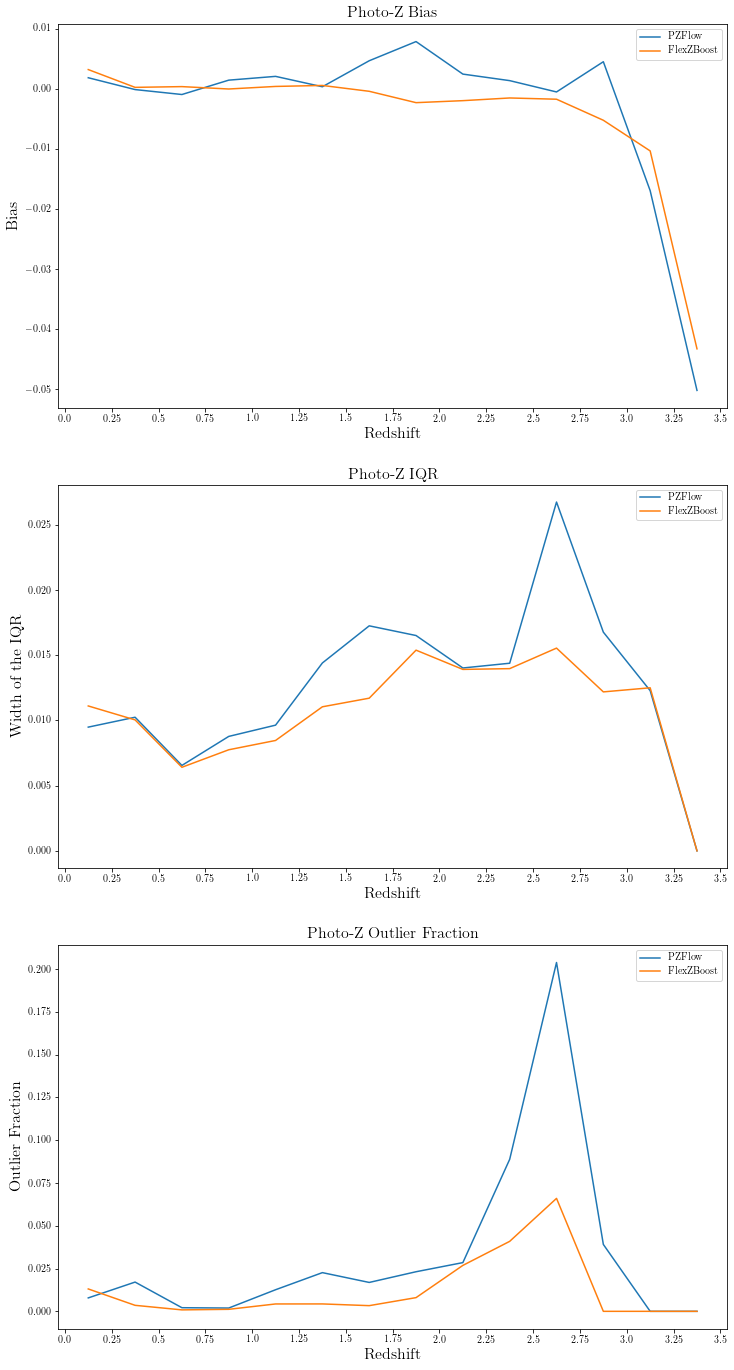

In [82]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(3,1,1)
plt.plot(np.arange(1, 15)-0.5, pzflow_bias_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_bias_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_bias_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Bias')

fig.add_subplot(3,1,2)
plt.plot(np.arange(1, 15)-0.5, pzflow_iqr_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_iqr_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_iqr_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the IQR')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z IQR')

fig.add_subplot(3,1,3)
plt.plot(np.arange(1, 15)-0.5, pzflow_outlier_vals, label='PZFlow')
plt.plot(np.arange(1, 15)-0.5, flex_outlier_vals, label='FlexZBoost')
#plt.plot(np.arange(1, 15)-0.5, bpz_outlier_vals, label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 15), labels=np.arange(0, 3.51, 0.25))
plt.title('Photo-Z Outlier Fraction')

In [84]:
np.arange(0, 3.51, 0.25)

DeviceArray([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25,
             2.5 , 2.75, 3.  , 3.25, 3.5 ], dtype=float32)

Text(0.5, 1.0, 'Photo-Z Outlier Fraction')

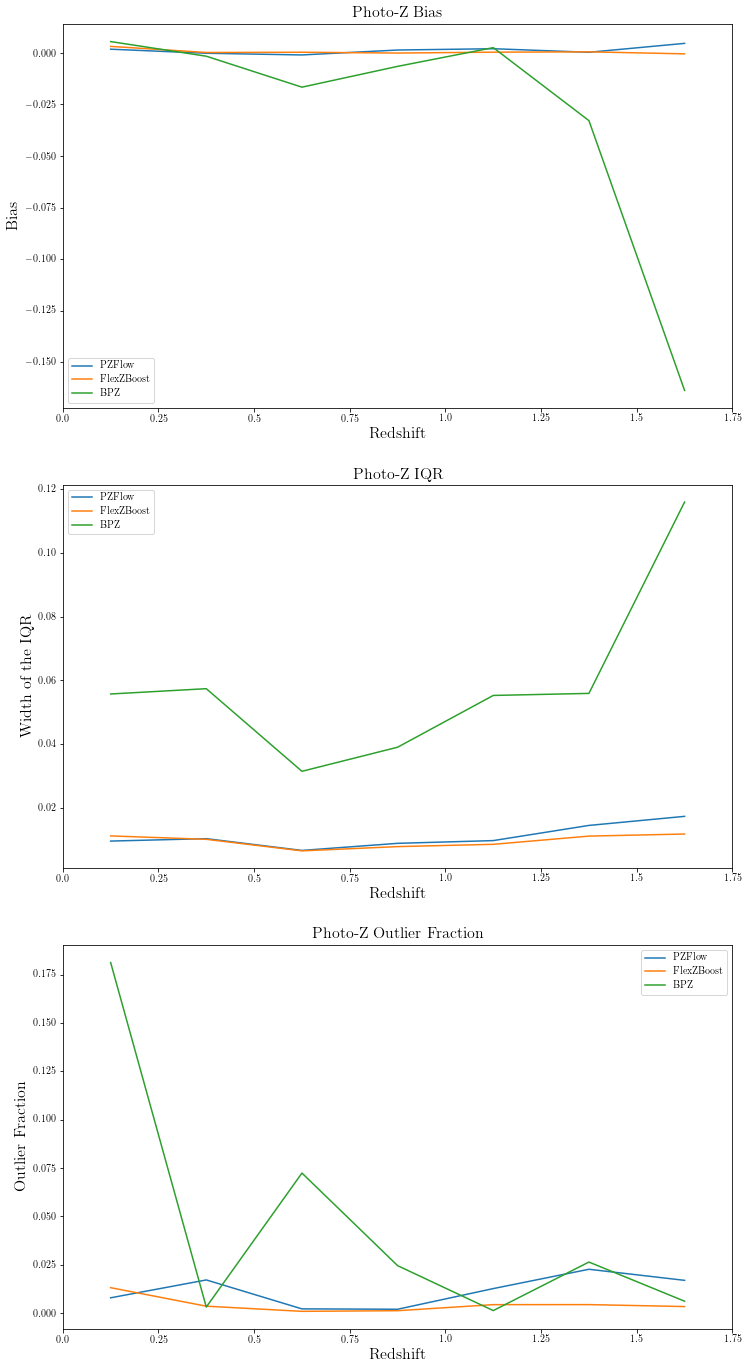

In [89]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(3,1,1)
plt.plot(np.arange(1, 8)-0.5, pzflow_bias_vals[:7], label='PZFlow')
plt.plot(np.arange(1, 8)-0.5, flex_bias_vals[:7], label='FlexZBoost')
plt.plot(np.arange(1, 8)-0.5, bpz_bias_vals[:7], label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 8), labels=np.arange(0, 1.76, 0.25))
plt.title('Photo-Z Bias')

fig.add_subplot(3,1,2)
plt.plot(np.arange(1, 8)-0.5, pzflow_iqr_vals[:7], label='PZFlow')
plt.plot(np.arange(1, 8)-0.5, flex_iqr_vals[:7], label='FlexZBoost')
plt.plot(np.arange(1, 8)-0.5, bpz_iqr_vals[:7], label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Width of the IQR')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 8), labels=np.arange(0, 1.76, 0.25))
plt.title('Photo-Z IQR')

fig.add_subplot(3,1,3)
plt.plot(np.arange(1, 8)-0.5, pzflow_outlier_vals[:7], label='PZFlow')
plt.plot(np.arange(1, 8)-0.5, flex_outlier_vals[:7], label='FlexZBoost')
plt.plot(np.arange(1, 8)-0.5, bpz_outlier_vals[:7], label='BPZ')
plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')
plt.legend()
ax = plt.gca()
ax.set_xticks(np.arange(0, 8), labels=np.arange(0, 1.76, 0.25))
plt.title('Photo-Z Outlier Fraction')

#### Point Metrics Over Full Sample

In [63]:
pzflow_bias_full_sample = PointBias(zmaxes, testset['redshift'].values).evaluate()
flex_bias_full_sample = PointBias(flex_results['zmode'], testset['redshift'].values).evaluate()
bpz_bias_full_sample = PointBias(bpz_results['zmode'], testset['redshift'].values).evaluate()
print(pzflow_bias_full_sample, flex_bias_full_sample, bpz_bias_full_sample)

0.0008150393 0.0001432794060090051 -0.015590353901269125


In [64]:
pzflow_sigmaIQR_full_sample = PointSigmaIQR(zmaxes, testset['redshift'].values).evaluate()
flex_sigmaIQR_full_sample = PointSigmaIQR(flex_results['zmode'], testset['redshift'].values).evaluate()
bpz_sigmaIQR_full_sample = PointSigmaIQR(bpz_results['zmode'], testset['redshift'].values).evaluate()
print(pzflow_sigmaIQR_full_sample, flex_sigmaIQR_full_sample, bpz_sigmaIQR_full_sample)

0.010120733679058908 0.009002721138235428 0.05581982158848459


In [65]:
pzflow_sigmaMAD_full_sample = PointSigmaMAD(zmaxes, testset['redshift'].values).evaluate()
flex_sigmaMAD_full_sample = PointSigmaMAD(flex_results['zmode'], testset['redshift'].values).evaluate()
bpz_sigmaMAD_full_sample = PointSigmaMAD(bpz_results['zmode'], testset['redshift'].values).evaluate()
print(pzflow_sigmaMAD_full_sample, flex_sigmaMAD_full_sample, bpz_sigmaMAD_full_sample)

0.01006794621683657 0.009001606265707307 0.055557884594783974


In [66]:
pzflow_outlier_full_sample = PointOutlierRate(zmaxes, testset['redshift'].values).evaluate()
flex_outlier_full_sample = PointOutlierRate(flex_results['zmode'], testset['redshift'].values).evaluate()
bpz_outlier_full_sample = PointOutlierRate(bpz_results['zmode'], testset['redshift'].values).evaluate()
print(pzflow_outlier_full_sample, flex_outlier_full_sample, bpz_outlier_full_sample)

0.01472 0.00512 0.1069


## Calculate PDF Metrics

### Calculate Brier Scores

In [90]:
from sklearn.metrics import brier_score_loss

In [91]:
from scipy.stats import norm
def test_z_pdf(z_est, z_err, dz, z_min, z_max):
    # Divide by 10 to get proper sampling with some very small uncertainties
    normed_val = norm.pdf(onp.arange(z_min, z_max+1e-6, dz/10), loc=z_est, scale=z_err)
    normed_sum = []
    for i in range(0, len(normed_val), 10):
        normed_sum.append(sum(normed_val[i:i+10])*(dz/10))
    if onp.sum(normed_sum) > 1.01:
        print(z_est, z_err)
    return normed_sum

In [92]:
z_min = 0
z_max = 3.5
dz = 0.01
z_arr = np.arange(z_min, z_max+1e-6, dz)

In [93]:
import numpy as onp

In [94]:
testset_bin_number = onp.digitize(testset['redshift'].values, z_arr)

In [95]:
testset_labels = onp.zeros((len(testset_bin_number), len(z_arr)))

In [96]:
for i, bin_num in list(enumerate(testset_bin_number)):
    testset_labels[i][bin_num] = 1

In [97]:
# https://stats.stackexchange.com/questions/403544/how-to-compute-the-brier-score-for-more-than-two-classes?rq=1

In [98]:
train_z_pdf, bin_edges = np.histogram(trainingset['redshift'].values, np.arange(0.00, 3.5101, 0.01))
train_z_pdf = np.array(train_z_pdf) / np.sum(train_z_pdf)

In [99]:
train_z_pdf = np.tile(train_z_pdf, len(testset_pdfs)).reshape(len(testset_pdfs), len(train_z_pdf))

In [100]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

In [105]:
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels, .01*onp.array(mean_test_pdfs)))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels, train_z_pdf))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels, bpz_results['pz_pdf']))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels, .01*flex_results['pz_pdf']))

PZFlow Brier Score: 0.8508
Train_Z Brier Score: 0.9944
BPZ Brier Score: 0.9872
FlexZBoost Brier Score: 0.8518


In [106]:
lessThan1p5 = np.where(testset['redshift'].values <= 1.5)[0]

In [107]:
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], .01*onp.array(mean_test_pdfs)[lessThan1p5]))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], train_z_pdf[lessThan1p5]))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], bpz_results['pz_pdf'][lessThan1p5]))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], .01*flex_results['pz_pdf'][lessThan1p5]))

PZFlow Brier Score: 0.8320
Train_Z Brier Score: 0.9928
BPZ Brier Score: 0.9769
FlexZBoost Brier Score: 0.8308


### Remove photometry in one of the bands

#### Create missing band data

##### g-band

In [142]:
test_data_missing_g = tables_io.io.read('test_cat.hdf5', None, train_fmt)['photometry']

In [143]:
test_data_missing_g['mag_err_g_lsst'] = np.zeros(len(test_data_missing_g['mag_err_r_lsst']))
test_data_missing_g['mag_g_lsst'] = -99.*np.zeros(len(test_data_missing_g['mag_err_r_lsst']))

##### u-band

In [103]:
test_data_missing_u = tables_io.io.read('test_cat.hdf5', None, train_fmt)['photometry']

In [104]:
test_data_missing_u['mag_err_u_lsst'] = np.zeros(len(test_data_missing_u['mag_err_r_lsst']))
test_data_missing_u['mag_u_lsst'] = -99.*np.zeros(len(test_data_missing_u['mag_err_r_lsst']))

#### BPZ with missing bands

##### BPZ with missing g

In [ ]:
%%time
bpz_results_missing_g = pz_bpz.estimate(test_data_missing_g)

In [ ]:
# with open('bpz_results_no_g', 'wb') as f:
#     pickle.dump(bpz_results_missing_g, f)

In [ ]:
with open('bpz_results_no_g', 'rb') as f:
    bpz_results_missing_g = pickle.load(f)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(test_data_missing_g['redshift'],bpz_results_missing_g['zmode'],s=1,c='k',label='bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

##### BPZ with missing u

In [146]:
%%time
bpz_results_missing_u = pz_bpz.estimate(test_data_missing_u)

CPU times: user 29.6 s, sys: 212 ms, total: 29.9 s
Wall time: 29.9 s


In [147]:
# with open('bpz_results_no_u', 'wb') as f:
#     pickle.dump(bpz_results_missing_u, f)

In [108]:
with open('bpz_results_no_u', 'rb') as f:
    bpz_results_missing_u = pickle.load(f)

Text(0, 0.5, 'bpz photo-z')

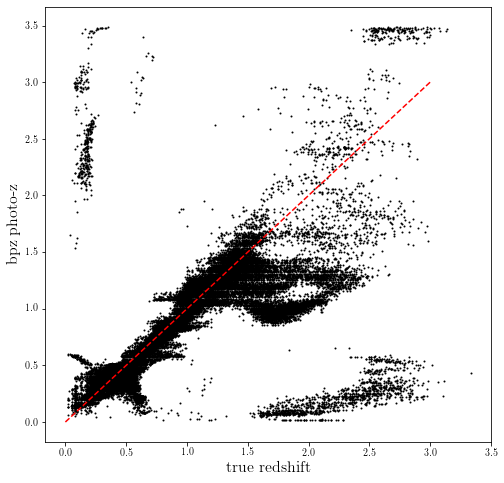

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(test_data_missing_u['redshift'],bpz_results_missing_u['zmode'],s=1,c='k',label='bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

#### pzflow with missing bands

##### pzflow with missing g

In [ ]:
np.max(training_data['mag_g_lsst']), np.min(training_data['mag_g_lsst'])

In [ ]:
marg_rules = {
    "flag": -99., # tells the posterior method that 99 means missing value
    "g": lambda row: np.linspace(np.min(training_data['mag_g_lsst']), np.max(training_data['mag_g_lsst']), 40), # the array of g values to marginalize over
}

In [ ]:
testset_missing_g = copy(testset)

In [ ]:
testset_missing_g['g'] = -99.

In [ ]:
%%time 
testset_pdfs_missing_g = flowEns.posterior(testset_missing_g, 'redshift', z_grid, batch_size=2500, seed=42, returnEnsemble=True, marg_rules=marg_rules)

In [ ]:
#np.save('testset_pdfs_missing_g.npy', testset_pdfs_missing_g)

In [ ]:
testset_pdfs_missing_g = np.load('testset_pdfs_missing_g.npy')

In [ ]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

In [ ]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_g[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

We can average across the ensemble PDFs to get a mean PDF estimate.

In [ ]:
mean_test_pdfs_missing_g = np.mean(testset_pdfs_missing_g, axis=1)

In [ ]:
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')

fig.add_subplot(1,3,2)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_g[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing g-band')

fig.add_subplot(1,3,3)
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')

In [ ]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
plt.xlim(0, 2)

fig.add_subplot(1,3,2)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_g[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing g-band')
plt.xlim(0, 2)

fig.add_subplot(1,3,3)
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
plt.xlim(0, 2)

In [ ]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 567
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')

fig.add_subplot(1,3,2)
n_flows = 4
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_g[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing g-band')

fig.add_subplot(1,3,3)
n_flows = 4
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')

In [ ]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 93
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
plt.xlim(0, 1)

fig.add_subplot(1,3,2)
n_flows = 4
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_g[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing g-band')
plt.xlim(0, 1)

fig.add_subplot(1,3,3)
n_flows = 4
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
plt.xlim(0, 1)

In [ ]:
%%time
pmaxes_no_g = np.array([np.max(pz) for pz in mean_test_pdfs_missing_g])
zmaxes_no_g = np.array([z_grid[pz.argmax()] for pz in mean_test_pdfs_missing_g])

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

plt.scatter(testset['redshift'], zmaxes, s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

plt.scatter(testset['redshift'][:len(zmaxes_no_g)], zmaxes_no_g, s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)

In [ ]:
fig = plt.figure(figsize=(24,12))

fig.add_subplot(1,2,1)
plt.scatter(testset['redshift'], zmaxes, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Full ugrizy photometry')

fig.add_subplot(1,2,2)
plt.scatter(testset['redshift'], zmaxes_no_g, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Marginalizing over missing g-band.')

plt.suptitle('PZ Flow results', size=16)
plt.subplots_adjust(top=.92)

In [ ]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(1,2,1)
plt.scatter(testset['redshift'], bpz_results['zmode'], s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Full ugrizy photometry')

fig.add_subplot(1,2,2)
plt.scatter(testset['redshift'], bpz_results_missing_g['zmode'], s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Marginalizing over missing g-band.')

plt.suptitle('BPZ results', size=16)
plt.subplots_adjust(top=.9)

In [ ]:
test_idx=93

In [ ]:
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], label='True Redshift')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], label='True Redshift')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(16, 5))
test_idx=93
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')

In [ ]:
fig = plt.figure(figsize=(16, 5))
test_idx=567
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')

In [ ]:
fig = plt.figure(figsize=(16, 5))
test_idx=110
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')

In [ ]:
fig = plt.figure(figsize=(16, 5))
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')
plt.xlim(0, 1.)

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')

In [ ]:
fig = plt.figure(figsize=(16, 5))
test_idx=11
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')

In [ ]:
fig = plt.figure(figsize=(16, 5))
test_idx=11
fig.add_subplot(1, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')
plt.xlim(0, 2)

fig.add_subplot(1, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_g['pz_pdf'][test_idx], label='BPZ Missing g')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_g[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing g")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing g-band photometry')
plt.xlim(0, 2)

In [ ]:
## Rerun Brier
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels, .01*onp.array(mean_test_pdfs_missing_g)))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels, train_z_pdf))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels, bpz_results_missing_g['pz_pdf']))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
#print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels, .01*flex_results['pz_pdf']))

In [ ]:
## Rerun Brier
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels, .01*onp.array(mean_test_pdfs_missing_g)))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels, train_z_pdf))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels, bpz_results_missing_u['pz_pdf']))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
#print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels, .01*flex_results['pz_pdf']))

##### pzflow with missing u

In [110]:
np.max(training_data['mag_u_lsst']), np.min(training_data['mag_u_lsst'])

(DeviceArray(26.09996, dtype=float32), DeviceArray(18.90768, dtype=float32))

In [111]:
marg_rules_u = {
    "flag": -99., # tells the posterior method that 99 means missing value
    "u": lambda row: np.linspace(np.min(training_data['mag_u_lsst']), np.max(training_data['mag_u_lsst']), 40), # the array of g values to marginalize over
}

In [112]:
testset_missing_u = copy(testset)

In [153]:
testset_missing_u['u'] = -99.

In [ ]:
%%time 
testset_pdfs_missing_u = flowEns.posterior(testset_missing_u, 'redshift', z_grid, batch_size=2500, seed=42, returnEnsemble=True, marg_rules=marg_rules_u)

In [ ]:
#np.save('testset_pdfs_missing_u.npy', testset_pdfs_missing_u)

In [113]:
testset_pdfs_missing_u = np.load('testset_pdfs_missing_u.npy')

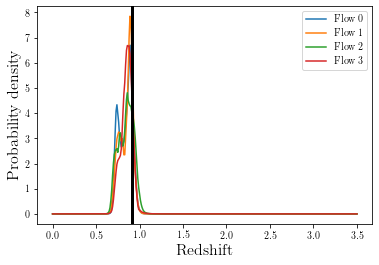

In [114]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

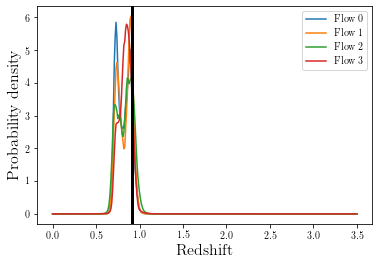

In [75]:
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

We can average across the ensemble PDFs to get a mean PDF estimate.

In [115]:
mean_test_pdfs_missing_u = np.mean(testset_pdfs_missing_u, axis=1)

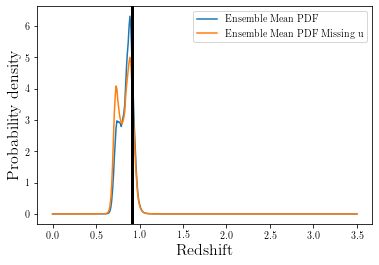

In [158]:
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
#plt.plot(z_grid, mean_test_pdfs_missing_g[idx], label=f"Ensemble Mean PDF Missing g")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()

Text(0.5, 1.0, 'Comparing Ensemble Mean PDFs')

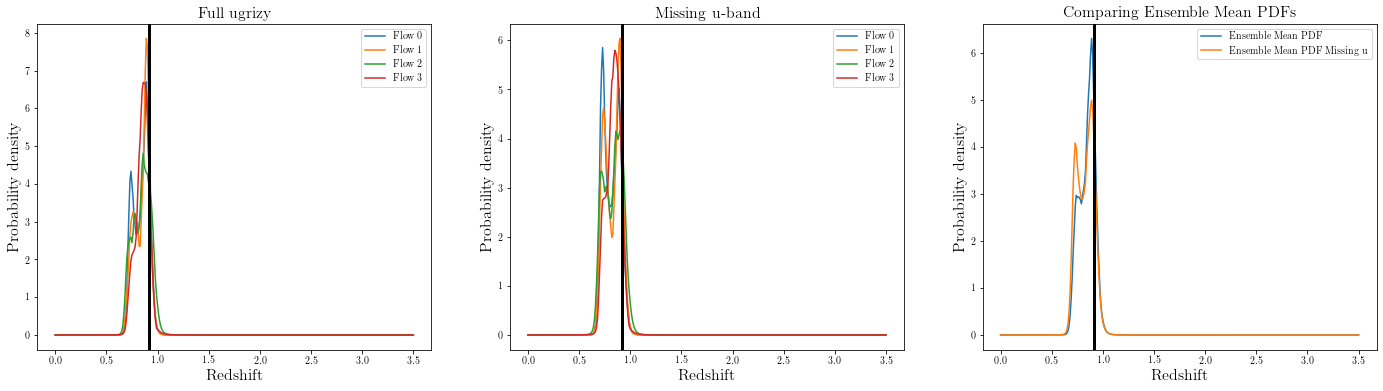

In [116]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')

fig.add_subplot(1,3,2)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')

fig.add_subplot(1,3,3)
n_flows = 4
idx = 11
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')

(0.0, 2.0)

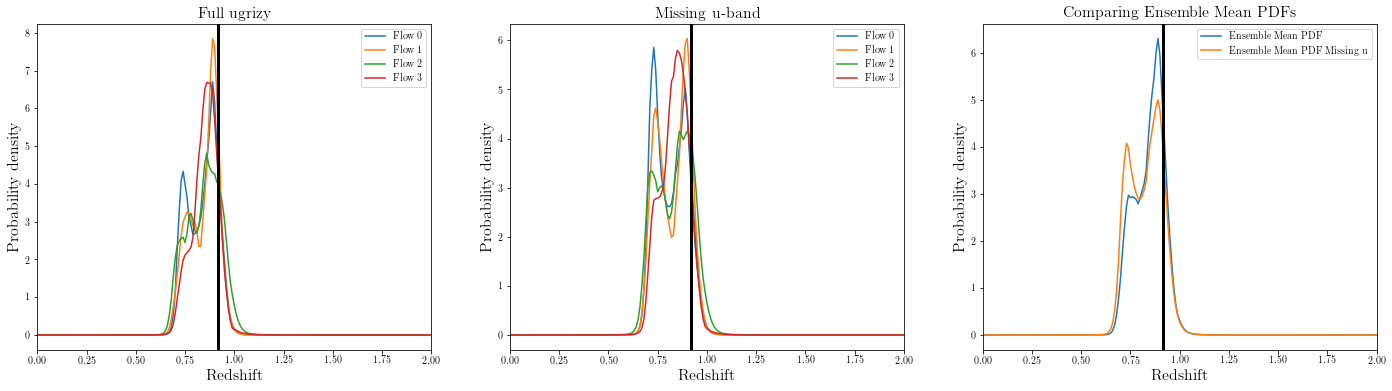

In [117]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 11
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
plt.xlim(0, 2)

fig.add_subplot(1,3,2)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')
plt.xlim(0, 2)

fig.add_subplot(1,3,3)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
plt.xlim(0, 2)

Text(0.5, 1.0, 'Comparing Ensemble Mean PDFs')

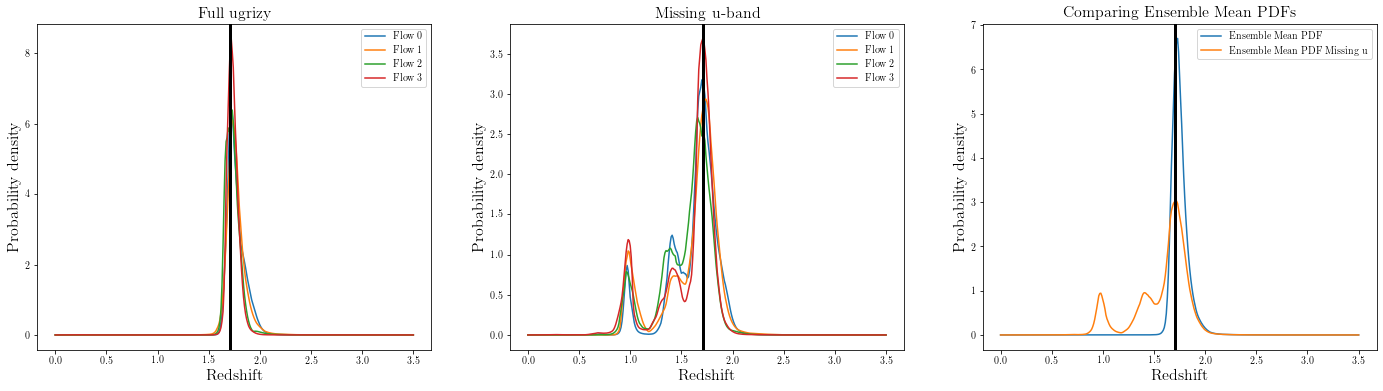

In [118]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 567
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
#plt.xlim(0, 2)

fig.add_subplot(1,3,2)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')
#plt.xlim(0, 2)

fig.add_subplot(1,3,3)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
#plt.xlim(0, 2)

(0.0, 1.0)

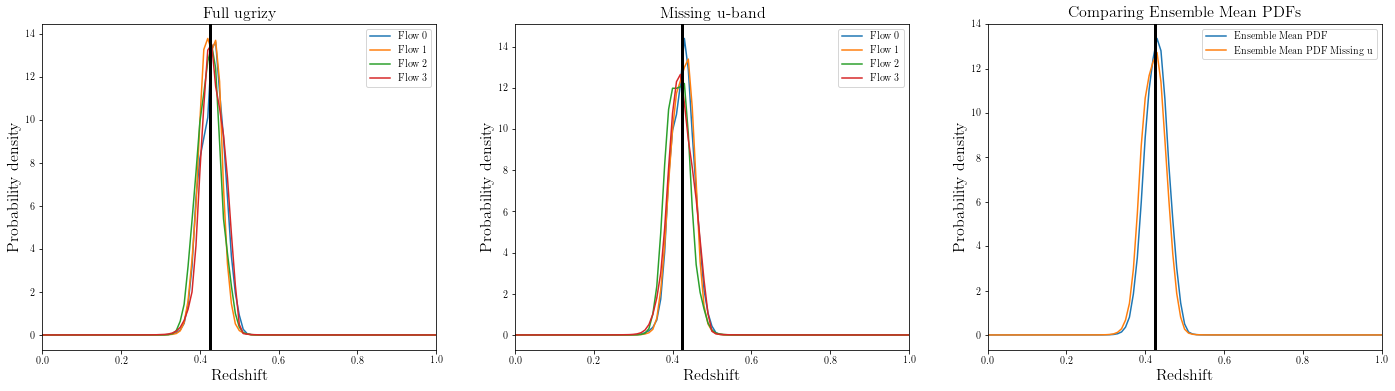

In [119]:
fig = plt.figure(figsize=(24, 6))

fig.add_subplot(1,3,1)
n_flows = 4
idx = 93
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
plt.xlim(0, 1)

fig.add_subplot(1,3,2)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')
plt.xlim(0, 1)

fig.add_subplot(1,3,3)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
plt.xlim(0, 1)

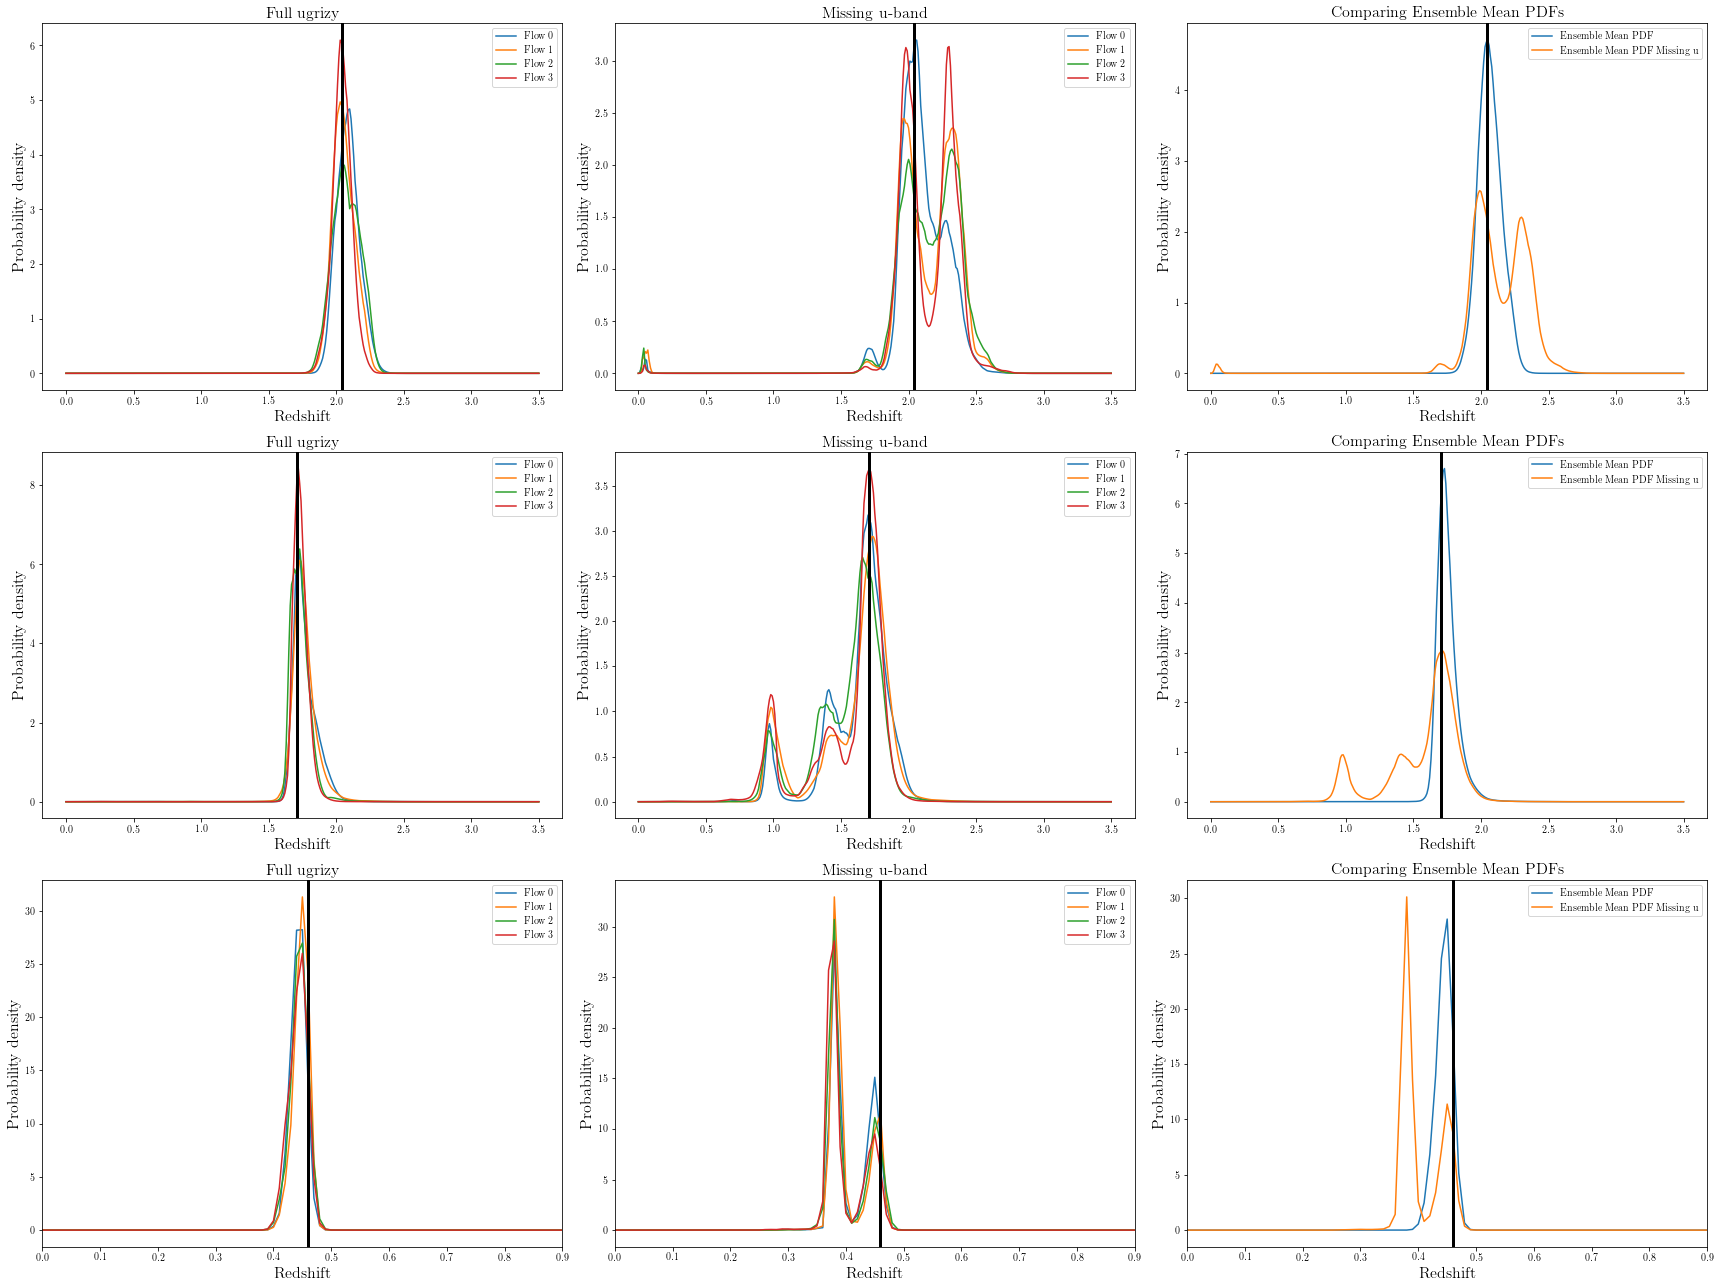

In [120]:
fig = plt.figure(figsize=(24, 18))

fig.add_subplot(3,3,1)
n_flows = 4
idx = 80
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
#plt.xlim(0, 1.5)

fig.add_subplot(3,3,2)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')
#plt.xlim(0, 1.5)

fig.add_subplot(3,3,3)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
#plt.xlim(0, 1.5)

fig.add_subplot(3,3,4)
n_flows = 4
idx = 567
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')

fig.add_subplot(3,3,5)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')

fig.add_subplot(3,3,6)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')

fig.add_subplot(3,3,7)
n_flows = 4
idx = 102
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Full ugrizy')
plt.xlim(0, 0.9)

fig.add_subplot(3,3,8)
for i in range(n_flows):
  plt.plot(z_grid, testset_pdfs_missing_u[idx][i], label=f"Flow {i}")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Missing u-band')
plt.xlim(0, 0.9)

fig.add_subplot(3,3,9)
plt.plot(z_grid, mean_test_pdfs[idx], label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[idx], label=f"Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[idx], 0, 1, lw=3, c='k')
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.title('Comparing Ensemble Mean PDFs')
plt.xlim(0, 0.9)
plt.tight_layout()

In [161]:
%%time
pmaxes_no_u = np.array([np.max(pz) for pz in mean_test_pdfs_missing_u])
zmaxes_no_u = np.array([z_grid[pz.argmax()] for pz in mean_test_pdfs_missing_u])

CPU times: user 54.5 s, sys: 10.5 s, total: 1min 5s
Wall time: 49 s


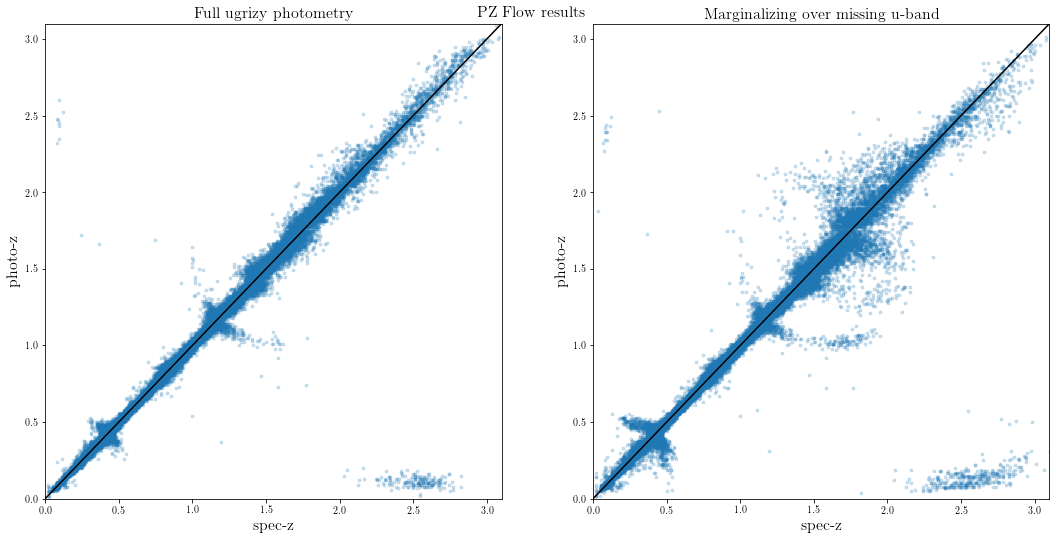

In [177]:
fig = plt.figure(figsize=(18,8))

fig.add_subplot(1,2,1)
plt.scatter(testset['redshift'], zmaxes, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Full ugrizy photometry')

fig.add_subplot(1,2,2)
plt.scatter(testset['redshift'], zmaxes_no_u, s=8, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Marginalizing over missing u-band')

plt.suptitle('PZ Flow results', size=16)
plt.subplots_adjust(top=.95)

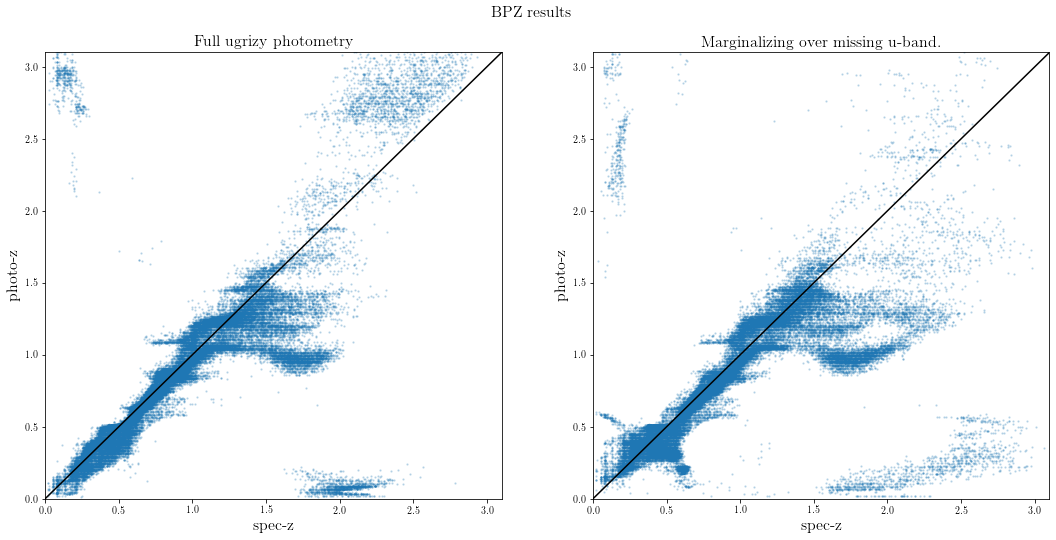

In [178]:
fig = plt.figure(figsize=(18,8))

fig.add_subplot(1,2,1)
plt.scatter(testset['redshift'], bpz_results['zmode'], s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Full ugrizy photometry')

fig.add_subplot(1,2,2)
plt.scatter(testset['redshift'], bpz_results_missing_u['zmode'], s=2, alpha=0.2)
plt.plot([0,3.1],[0,3.1], c='k')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.title('Marginalizing over missing u-band.')

plt.suptitle('BPZ results', size=16)
plt.subplots_adjust(top=.9)

In [299]:
initial_res = np.abs(bpz_results['zmode'] - testset['redshift'].values)
no_u_res = np.abs(bpz_results_missing_u['zmode'] - testset['redshift'].values)

In [303]:
np.where((initial_res < 0.1) & (no_u_res > 0.1))[0][:100]

DeviceArray([   2,   30,   33,   75,   80,  102,  113,  122,  125,  126,
              167,  190,  213,  214,  217,  225,  228,  237,  241,  253,
              271,  274,  337,  339,  350,  353,  369,  377,  395,  402,
              405,  406,  408,  411,  418,  442,  448,  453,  457,  498,
              503,  505,  511,  519,  523,  547,  584,  595,  598,  599,
              609,  624,  626,  632,  647,  661,  680,  686,  701,  750,
              753,  754,  770,  782,  787,  788,  804,  807,  844,  847,
              852,  866,  899,  911,  932,  961,  977,  987,  990,  995,
             1002, 1005, 1007, 1035, 1046, 1050, 1056, 1058, 1073, 1076,
             1077, 1084, 1107, 1115, 1132, 1141, 1154, 1156, 1160, 1161],            dtype=int32)

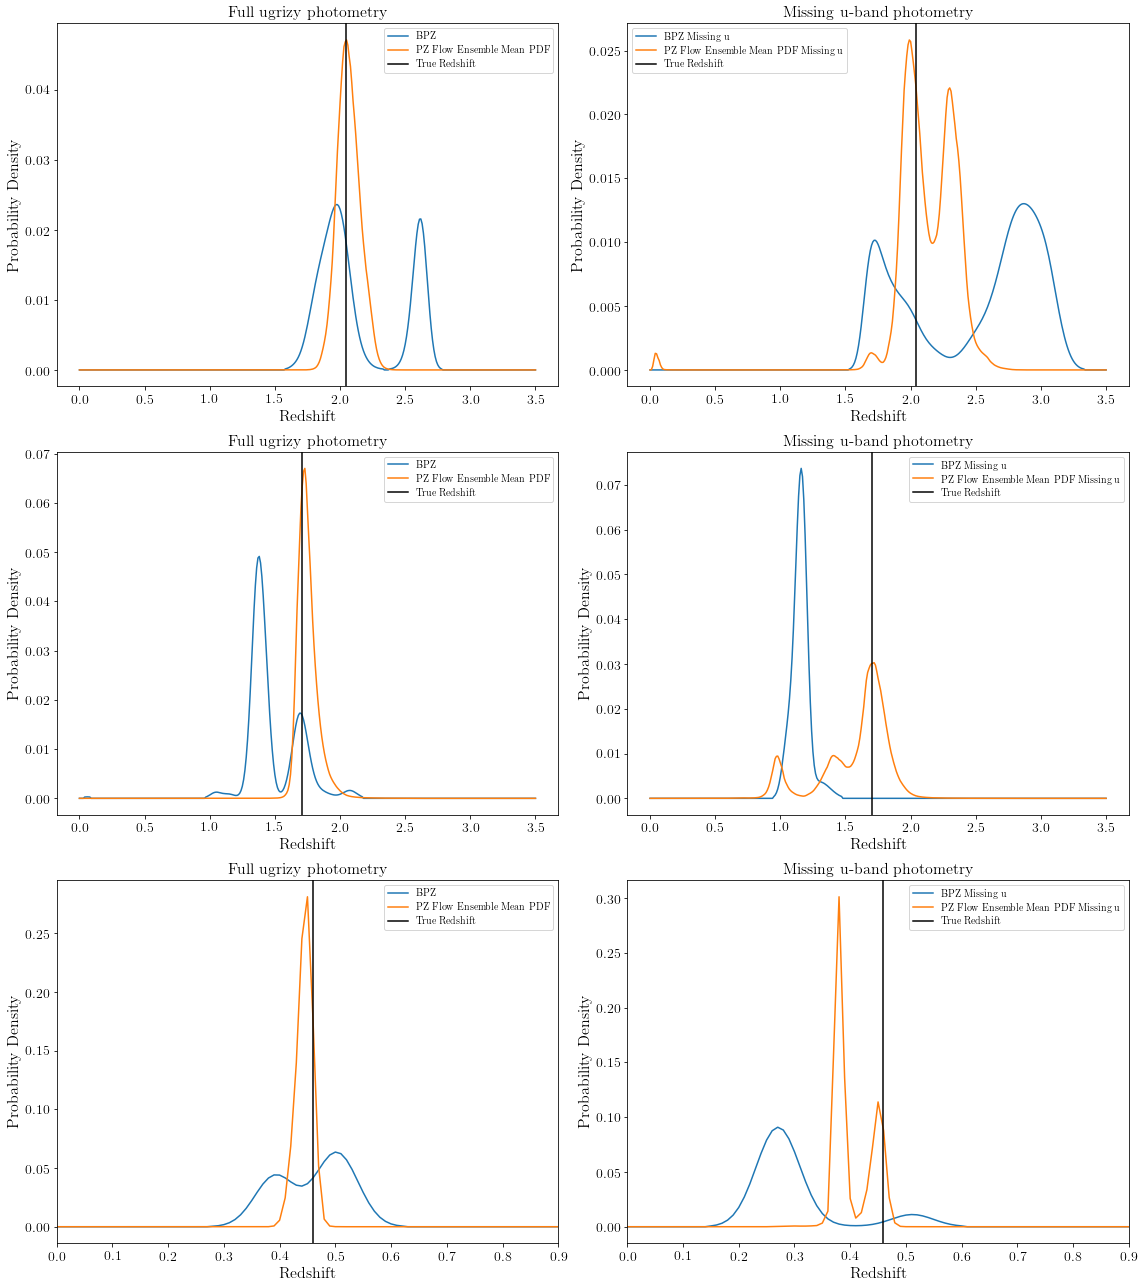

In [335]:
fig = plt.figure(figsize=(16, 18))

test_idx=80
fig.add_subplot(3, 2, 1)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xlim(0, 2.4)

fig.add_subplot(3, 2, 2)
plt.plot(pz_bpz.zgrid, bpz_results_missing_u['pz_pdf'][test_idx], label='BPZ Missing u')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing u-band photometry')
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xlim(0, 2.4)

test_idx=567
fig.add_subplot(3, 2, 3)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xlim(0, 2.4)

fig.add_subplot(3, 2, 4)
plt.plot(pz_bpz.zgrid, bpz_results_missing_u['pz_pdf'][test_idx], label='BPZ Missing u')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing u-band photometry')
plt.xticks(size=14)
plt.yticks(size=14)
#plt.xlim(0, 2.4)

test_idx=102
fig.add_subplot(3, 2, 5)
plt.plot(pz_bpz.zgrid, bpz_results['pz_pdf'][test_idx], label='BPZ')
plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"PZ Flow Ensemble Mean PDF")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Full ugrizy photometry')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(0, 0.9)

fig.add_subplot(3, 2, 6)
plt.plot(pz_bpz.zgrid, bpz_results_missing_u['pz_pdf'][test_idx], label='BPZ Missing u')
#plt.plot(z_grid, mean_test_pdfs[test_idx]/np.sum(mean_test_pdfs[test_idx]), label=f"Ensemble Mean PDF")
plt.plot(z_grid, mean_test_pdfs_missing_u[test_idx]*.01, label=f"PZ Flow Ensemble Mean PDF Missing u")
plt.axvline(testset['redshift'].iloc[test_idx], c='k', label='True Redshift')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Missing u-band photometry')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(0, 0.9)

plt.tight_layout()

In [121]:
## Rerun Brier
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels, .01*onp.array(mean_test_pdfs_missing_u)))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels, train_z_pdf))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels, bpz_results_missing_u['pz_pdf']))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
#print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels, .01*flex_results['pz_pdf']))

PZFlow Brier Score: 0.8683
Train_Z Brier Score: 0.9944
BPZ Brier Score: 0.9930


In [123]:
## Rerun Brier
# print('CMNN Brier Score: %.4f' % brier_multi(testset_labels, cmnn_pdfs))
print('PZFlow Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], .01*onp.array(mean_test_pdfs_missing_u)[lessThan1p5]))
print('Train_Z Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], train_z_pdf[lessThan1p5]))
print('BPZ Brier Score: %.4f' % brier_multi(testset_labels[lessThan1p5], bpz_results_missing_u['pz_pdf'][lessThan1p5]))
#print('SimpleNN Brier Score: %.4f' % brier_multi(testset_labels, results_dict['pz_pdf']))
#print('FlexZBoost Brier Score: %.4f' % brier_multi(testset_labels, .01*flex_results['pz_pdf']))

PZFlow Brier Score: 0.8484
Train_Z Brier Score: 0.9928
BPZ Brier Score: 0.9845


## PZDC1 Metrics

In [202]:
from rail.evaluation.metrics.pit import PIT

In [203]:
# This is a trivial extension, with the number of pdfs as a member of the `scipy.stats.norm_gen` distribution.
loc = np.array([[0],[1]])
scale = np.array([[1],[1]])
norm_dist = qp.stats.norm(loc=loc, scale=scale)
xvals = np.linspace(-5, 5, 51)
yvals = norm_dist.pdf(xvals)

In [204]:
locs = 2* (onp.random.uniform(size=(100,1))-0.5)
scales = 1 + 0.2*(onp.random.uniform(size=(100,1))-0.5)
ens_n = qp.Ensemble(qp.stats.norm, data=dict(loc=locs, scale=scales))

In [205]:
ens_pzflow = qp.Ensemble(qp.hist, data=dict(bins=z_grid_extended, pdfs=mean_test_pdfs.to_py()))

In [206]:
pit_pzflow = PIT(ens_pzflow, testset['redshift'].values)

In [207]:
pit_pzflow_results, pit_pzflow_metamets = pit_pzflow.evaluate()

/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [208]:
pit_pzflow_bins, pit_pzflow_vals = pit_pzflow_results.histogramize(np.linspace(0, 1, 101))

Text(0.5, 1.0, 'PZFLOW PIT Results')

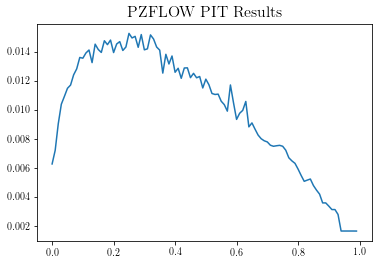

In [231]:
plt.plot(pit_pzflow_bins[:-1], pit_pzflow_vals[0])
plt.title('PZFLOW PIT Results')

In [232]:
pit_pzflow_metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 6.828193098401154e-05,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=2366.48472437835, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

In [233]:
ens_bpz = qp.Ensemble(qp.hist, data=dict(bins=z_grid_extended, pdfs=bpz_results['pz_pdf']))

pit_bpz = PIT(ens_bpz, testset['redshift'].values)

pit_bpz_results, pit_bpz_metamets = pit_bpz.evaluate()

1740 PITs removed from the sample.


/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [234]:
pit_bpz_bins, pit_bpz_vals = pit_bpz_results.histogramize(np.linspace(0, 1, 101))

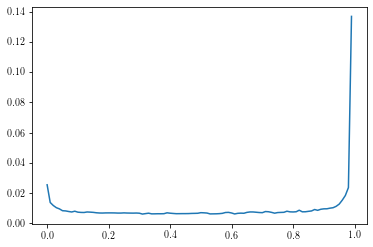

In [235]:
plt.plot(pit_bpz_bins[:-1], pit_bpz_vals[0])

In [236]:
pit_bpz_metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 0.16383663076055593,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=2562.9230501622164, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

In [237]:
ens_flex = qp.Ensemble(qp.hist, data=dict(bins=z_grid_extended, pdfs=flex_results['pz_pdf']))

In [238]:
pit_flex = PIT(ens_flex, testset['redshift'].values)

In [239]:
pit_flex_results, pit_flex_metamets = pit_flex.evaluate()

327 PITs removed from the sample.


/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [240]:
pit_flex_bins, pit_flex_vals = pit_flex_results.histogramize(bins=np.linspace(0, 1, 101))

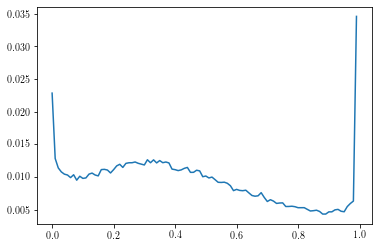

In [241]:
plt.plot(pit_flex_bins[:-1], pit_flex_vals[0])

In [242]:
pit_flex_metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 0.09176238471005098,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=1873.511223511927, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

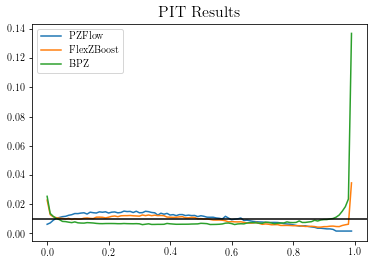

In [243]:
plt.plot(pit_pzflow_bins[:-1], pit_pzflow_vals[0], label='PZFlow')
plt.plot(pit_flex_bins[:-1], pit_flex_vals[0], label='FlexZBoost')
plt.plot(pit_bpz_bins[:-1], pit_bpz_vals[0], label='BPZ')
plt.title('PIT Results')
plt.axhline(0.01, 0, 1, c='k')
plt.legend()

Text(0, 0.5, 'Fractional Bin Count')

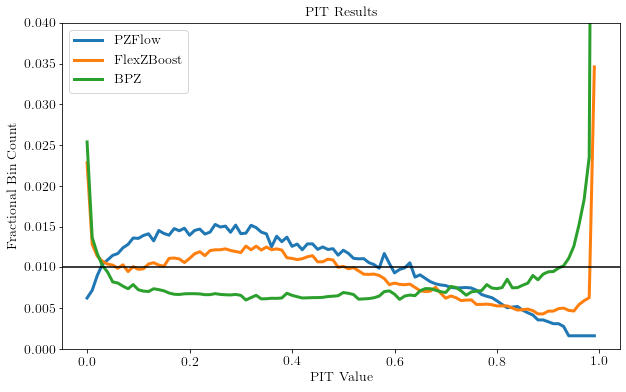

In [329]:
fig = plt.figure(figsize=(10, 6))
plt.plot(pit_pzflow_bins[:-1], pit_pzflow_vals[0], label='PZFlow', lw=3)
plt.plot(pit_flex_bins[:-1], pit_flex_vals[0], label='FlexZBoost', lw=3)
plt.plot(pit_bpz_bins[:-1], pit_bpz_vals[0], label='BPZ', lw=3)
plt.title('PIT Results', size=14)
plt.axhline(0.01, 0, 1, c='k')
plt.legend(fontsize=14)
plt.ylim(0, 0.04)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('PIT Value', size=14)
plt.ylabel('Fractional Bin Count', size=14)

#### Missing bands

##### Missing u-band

In [245]:
ens_pzflow_missing_u = qp.Ensemble(qp.hist, data=dict(bins=z_grid_extended, pdfs=mean_test_pdfs_missing_u.to_py()))

In [246]:
pit_pzflow_missing_u = PIT(ens_pzflow_missing_u, testset['redshift'].values)

In [247]:
pit_pzflow_missing_u_results, pit_pzflow_missing_u_metamets = pit_pzflow_missing_u.evaluate()

/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [248]:
pit_pzflow_missing_u_bins, pit_pzflow_missing_u_vals = pit_pzflow_missing_u_results.histogramize(np.linspace(0, 1, 101))

Text(0.5, 1.0, 'PZFLOW PIT Results with no u-band photometry')

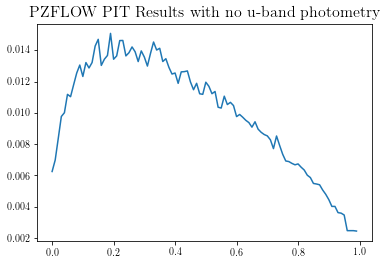

In [249]:
plt.plot(pit_pzflow_missing_u_bins[:-1], pit_pzflow_missing_u_vals[0])
plt.title('PZFLOW PIT Results with no u-band photometry')

In [250]:
pit_pzflow_missing_u_metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 5.4192877369162686e-05,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=1627.725442103223, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

In [251]:
ens_bpz_missing_u = qp.Ensemble(qp.hist, data=dict(bins=z_grid_extended, pdfs=bpz_results_missing_u['pz_pdf']))

pit_bpz_missing_u = PIT(ens_bpz_missing_u, testset['redshift'].values)

pit_bpz_missing_u_results, pit_bpz_missing_u_metamets = pit_bpz_missing_u.evaluate()

1868 PITs removed from the sample.


/astro/users/brycek/brycek_epyc/pzflow-paper-2021-jbkalmbach/pzflow-paper-2021/photo-z/RAIL/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [252]:
pit_bpz_missing_u_bins, pit_bpz_missing_u_vals = pit_bpz_missing_u_results.histogramize(np.linspace(0, 1, 101))

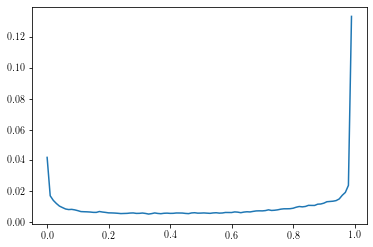

In [253]:
plt.plot(pit_bpz_missing_u_bins[:-1], pit_bpz_missing_u_vals[0])

In [254]:
pit_bpz_missing_u_metamets

{(rail.evaluation.metrics.pit.PITOutRate, 'default'): 0.14417904082694807,
 (rail.evaluation.metrics.pit.PITAD,
  'default'): stat_crit_sig(statistic=3216.903252938777, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}

Text(0, 0.5, 'Fractional Bin Count')

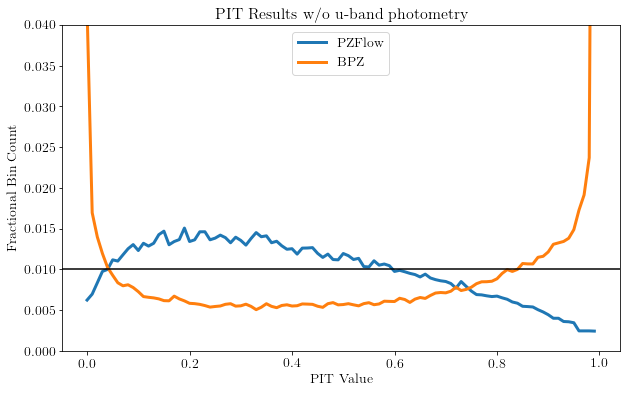

In [328]:
fig = plt.figure(figsize=(10, 6))
plt.plot(pit_pzflow_missing_u_bins[:-1], pit_pzflow_missing_u_vals[0], label='PZFlow', lw=3)
#plt.plot(pit_flex_bins[:-1], pit_flex_vals[0], label='FlexZBoost')
plt.plot(pit_bpz_missing_u_bins[:-1], pit_bpz_missing_u_vals[0], label='BPZ', lw=3)
plt.axhline(0.01, 0, 1, c='k')
plt.title('PIT Results w/o u-band photometry')
plt.legend(loc=9, fontsize=14)
plt.ylim(0, 0.04)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('PIT Value', size=14)
plt.ylabel('Fractional Bin Count', size=14)

Text(0, 0.5, 'Fractional Bin Count')

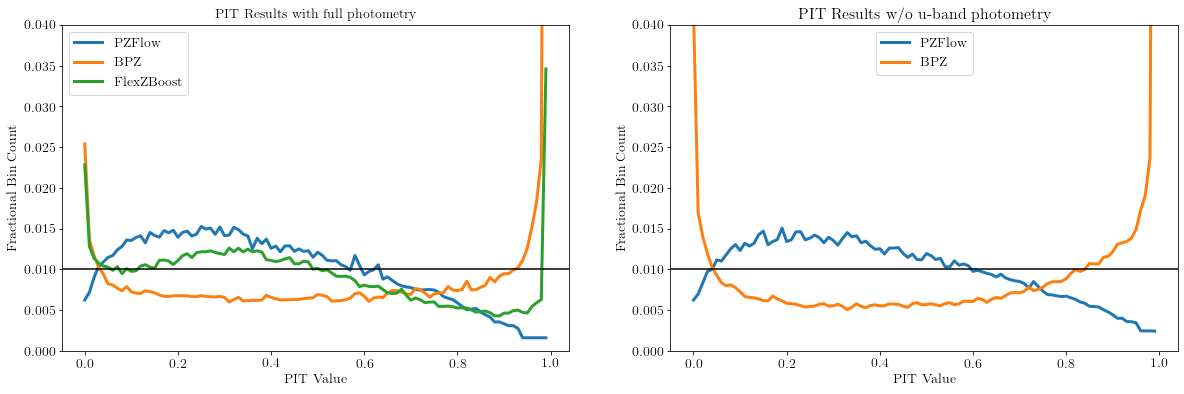

In [337]:
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(pit_pzflow_bins[:-1], pit_pzflow_vals[0], label='PZFlow', lw=3)
plt.plot(pit_bpz_bins[:-1], pit_bpz_vals[0], label='BPZ', lw=3)
plt.plot(pit_flex_bins[:-1], pit_flex_vals[0], label='FlexZBoost', lw=3)
plt.title('PIT Results with full photometry', size=14)
plt.axhline(0.01, 0, 1, c='k')
plt.legend(fontsize=14)
plt.ylim(0, 0.04)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('PIT Value', size=14)
plt.ylabel('Fractional Bin Count', size=14)

fig.add_subplot(1,2,2)
plt.plot(pit_pzflow_missing_u_bins[:-1], pit_pzflow_missing_u_vals[0], label='PZFlow', lw=3)
#plt.plot(pit_flex_bins[:-1], pit_flex_vals[0], label='FlexZBoost')
plt.plot(pit_bpz_missing_u_bins[:-1], pit_bpz_missing_u_vals[0], label='BPZ', lw=3)
plt.axhline(0.01, 0, 1, c='k')
plt.title('PIT Results w/o u-band photometry')
plt.legend(loc=9, fontsize=14)
plt.ylim(0, 0.04)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('PIT Value', size=14)
plt.ylabel('Fractional Bin Count', size=14)